# Insurance Premium Prediction

#### Problem Statement
The goal of this dataset is to facilitate the development and testing of regression models for predicting insurance premiums based on various customer characteristics and policy details. Insurance companies often rely on data-driven approaches to estimate premiums, taking into account factors such as age, income, health status, and claim history. This synthetic dataset simulates real-world scenarios to help practitioners practice feature engineering, data cleaning, and model training.

#### Dataset Overview
This dataset contains 1.2 million and 20 features with a mix of categorical, numerical, and text data. It includes missing values, incorrect data types, and skewed distributions to mimic the complexities faced in real-world datasets. The target variable for prediction is the "Premium Amount".

#### Source
https://www.kaggle.com/competitions/playground-series-s4e12/data

## LIBRARIES AND DATA IMPORT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define function for use in outliers removal, the method that we'll use is IQR based
def outlier_fx(data, parameter):
    q1 = data[parameter].quantile(0.25)
    q3 = data[parameter].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    clean = data[(data[parameter] >= lower) & (data[parameter] <= upper)]
    return clean

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/bootcamp batch9/train.csv')
data

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,...,NaN,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0
1199996,1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,...,NaN,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0
1199997,1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,...,0.0,19.0,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0
1199998,1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,...,1.0,7.0,407.0,4.0,2021-09-19 15:21:39.190215,Poor,No,Daily,Apartment,596.0


## EDA: DATA CLEANING AND DISTRIBUTION CHECK

In [ ]:
# Let's try to check the Null ammount
data.isnull().sum()

,0
id,0
Age,18705
Gender,0
Annual Income,44949
Marital Status,18529
Number of Dependents,109672
Education Level,0
Occupation,358075
Health Score,74076
Location,0


Let's start by changing the Policy Start Date to epoch format so we can investigate further

In [ ]:
data['Policy Start Date'] = data['Policy Start Date'].str.replace('\n', ' ')
data['datetime'] = pd.to_datetime(data['Policy Start Date'], format="%Y-%m-%d %H:%M:%S.%f")

# Step 2: Convert to Unix timestamp in hours
data['hours_since_epoch'] = data['datetime'].astype('int64') // 10**9 // 3600
data

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,datetime,hours_since_epoch
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0,2023-12-23 15:21:39.134960,473151
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0,2023-06-12 15:21:39.111551,468495
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0,2023-09-30 15:21:39.221386,471135
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0,2024-06-12 15:21:39.226954,477279
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0,2021-12-01 15:21:39.252145,455103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,...,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0,2023-05-03 15:21:39.257696,467535
1199996,1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,...,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0,2022-09-10 15:21:39.134960,461895
1199997,1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,...,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0,2021-05-25 15:21:39.106582,450543
1199998,1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,...,407.0,4.0,2021-09-19 15:21:39.190215,Poor,No,Daily,Apartment,596.0,2021-09-19 15:21:39.190215,453351


Let's drop ID because it's only a tag, Policy Start Date and Datetime because we have converted them to Epoch Format. Customer Feedback and Previous Claims because it's not related to how people place Premium amount

In [ ]:
data.drop(columns=['id', 'Customer Feedback', 'Previous Claims', 'Policy Start Date', 'datetime'], inplace=True)
data

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Smoking Status,Exercise Frequency,Property Type,Premium Amount,hours_since_epoch
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,17.0,372.0,5.0,No,Weekly,House,2869.0,473151
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,12.0,694.0,2.0,Yes,Monthly,House,1483.0,468495
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,14.0,NaN,3.0,Yes,Weekly,House,567.0,471135
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,0.0,367.0,1.0,Yes,Daily,Apartment,765.0,477279
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,8.0,598.0,4.0,Yes,Weekly,House,2022.0,455103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,5.0,372.0,3.0,No,Daily,Apartment,1303.0,467535
1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,10.0,597.0,4.0,No,Weekly,Apartment,821.0,461895
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,19.0,NaN,6.0,No,Monthly,Condo,371.0,450543
1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,Premium,7.0,407.0,4.0,No,Daily,Apartment,596.0,453351


We'll `dropna` directly some of the features, but before that let's check the distributions before and after `dropna`

In [ ]:
b = data.loc[(data['Age'].isnull()) |
             (data['Annual Income'].isnull()), :]

<ipython-input-9-086e071ef497>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c.dropna(inplace=True)


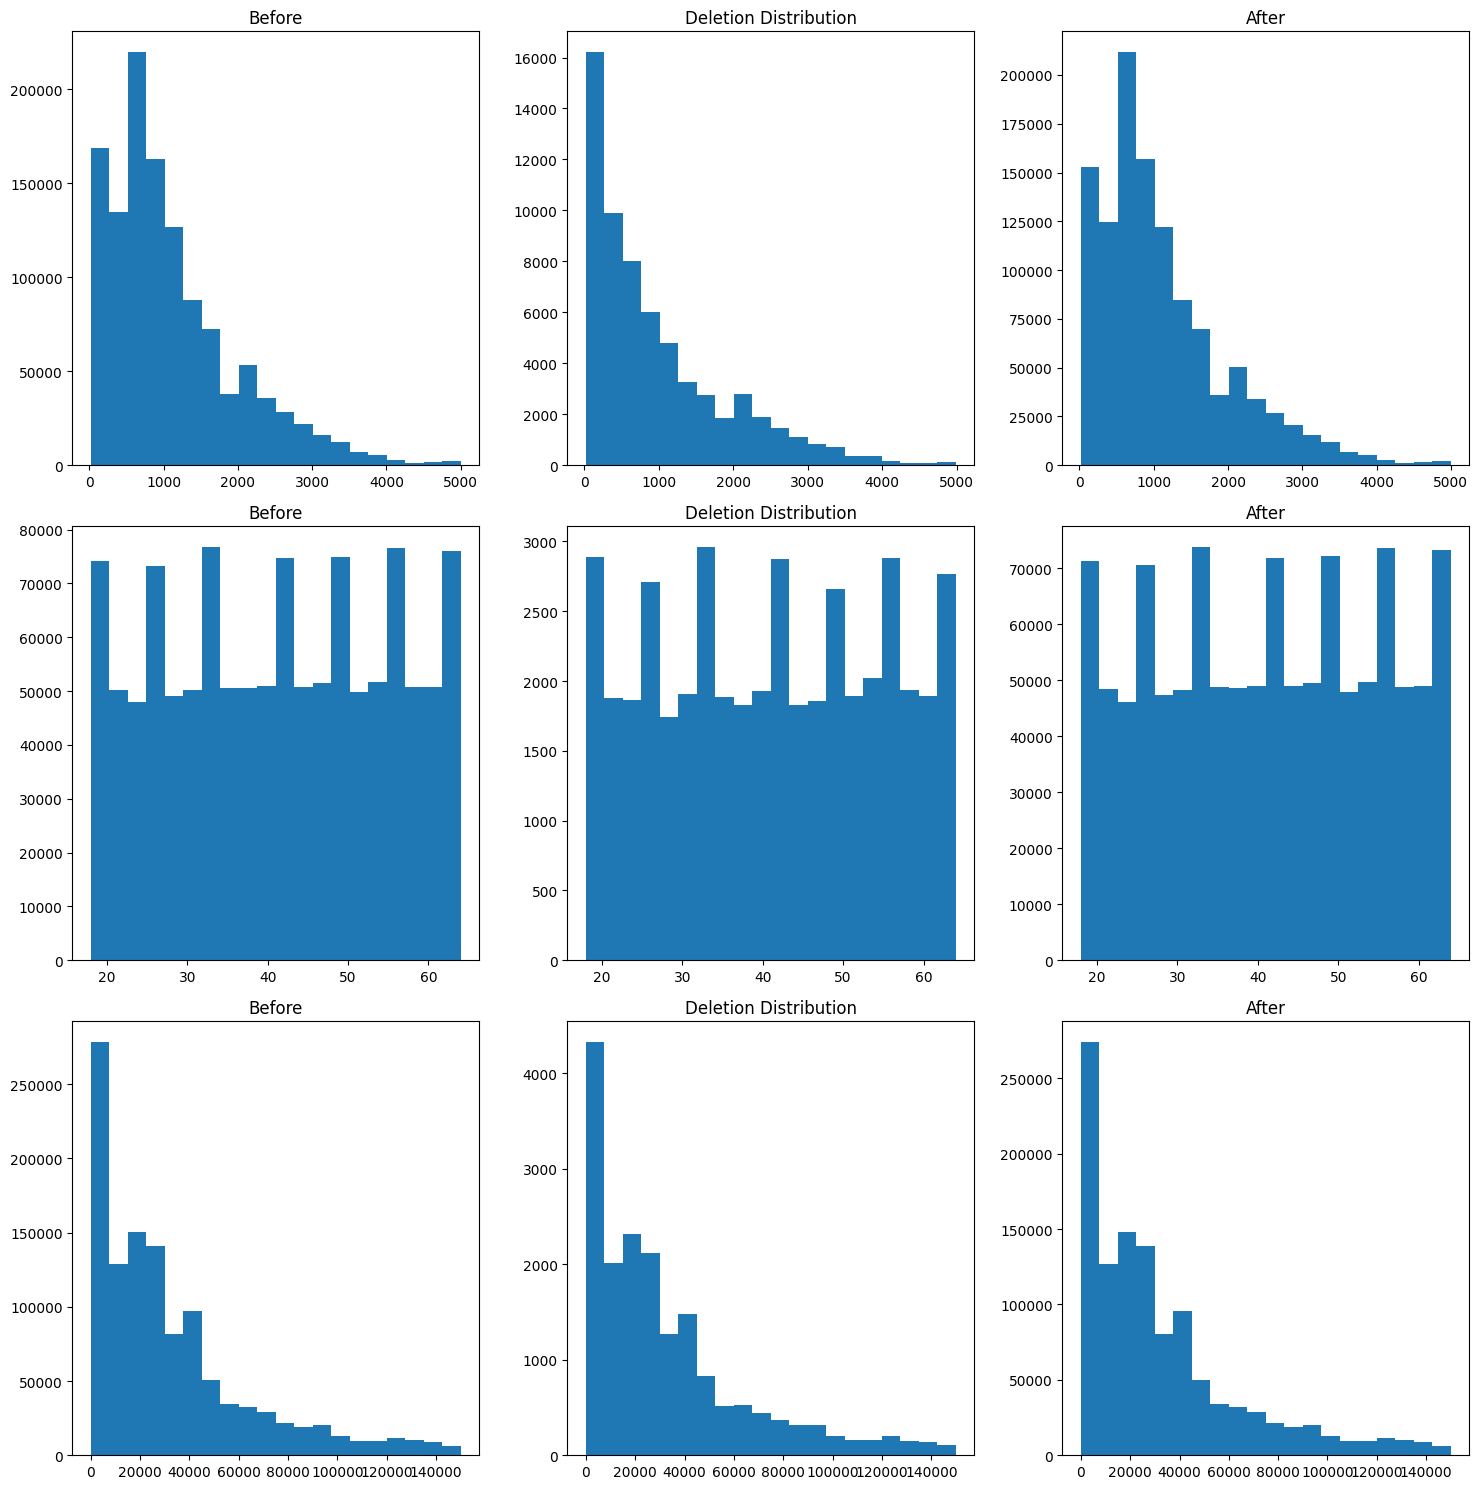

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(331)
plt.hist(x=data['Premium Amount'].values, bins=20)
plt.title('Before')

plt.subplot(332)
plt.hist(x=b['Premium Amount'].values, bins=20)
plt.title('Deletion Distribution')

c = data[['Age', 'Annual Income', 'Premium Amount']]
c.dropna(inplace=True)
plt.subplot(333)
plt.hist(x=c[['Premium Amount']].values, bins=20)
plt.title('After')

plt.subplot(334)
plt.hist(x=data['Age'].values, bins=20)
plt.title('Before')

plt.subplot(335)
plt.hist(x=b['Age'].values, bins=20)
plt.title('Deletion Distribution')

plt.subplot(336)
plt.hist(x=c[['Age']].values, bins=20)
plt.title('After')

plt.subplot(337)
plt.hist(x=data['Annual Income'].values, bins=20)
plt.title('Before')

plt.subplot(338)
plt.hist(x=b['Annual Income'].values, bins=20)
plt.title('Deletion Distribution')

plt.subplot(339)
plt.hist(x=c[['Annual Income']].values, bins=20)
plt.title('After')

plt.tight_layout()
plt.show()

<ipython-input-10-fae3fa56d1b8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c.dropna(inplace=True)


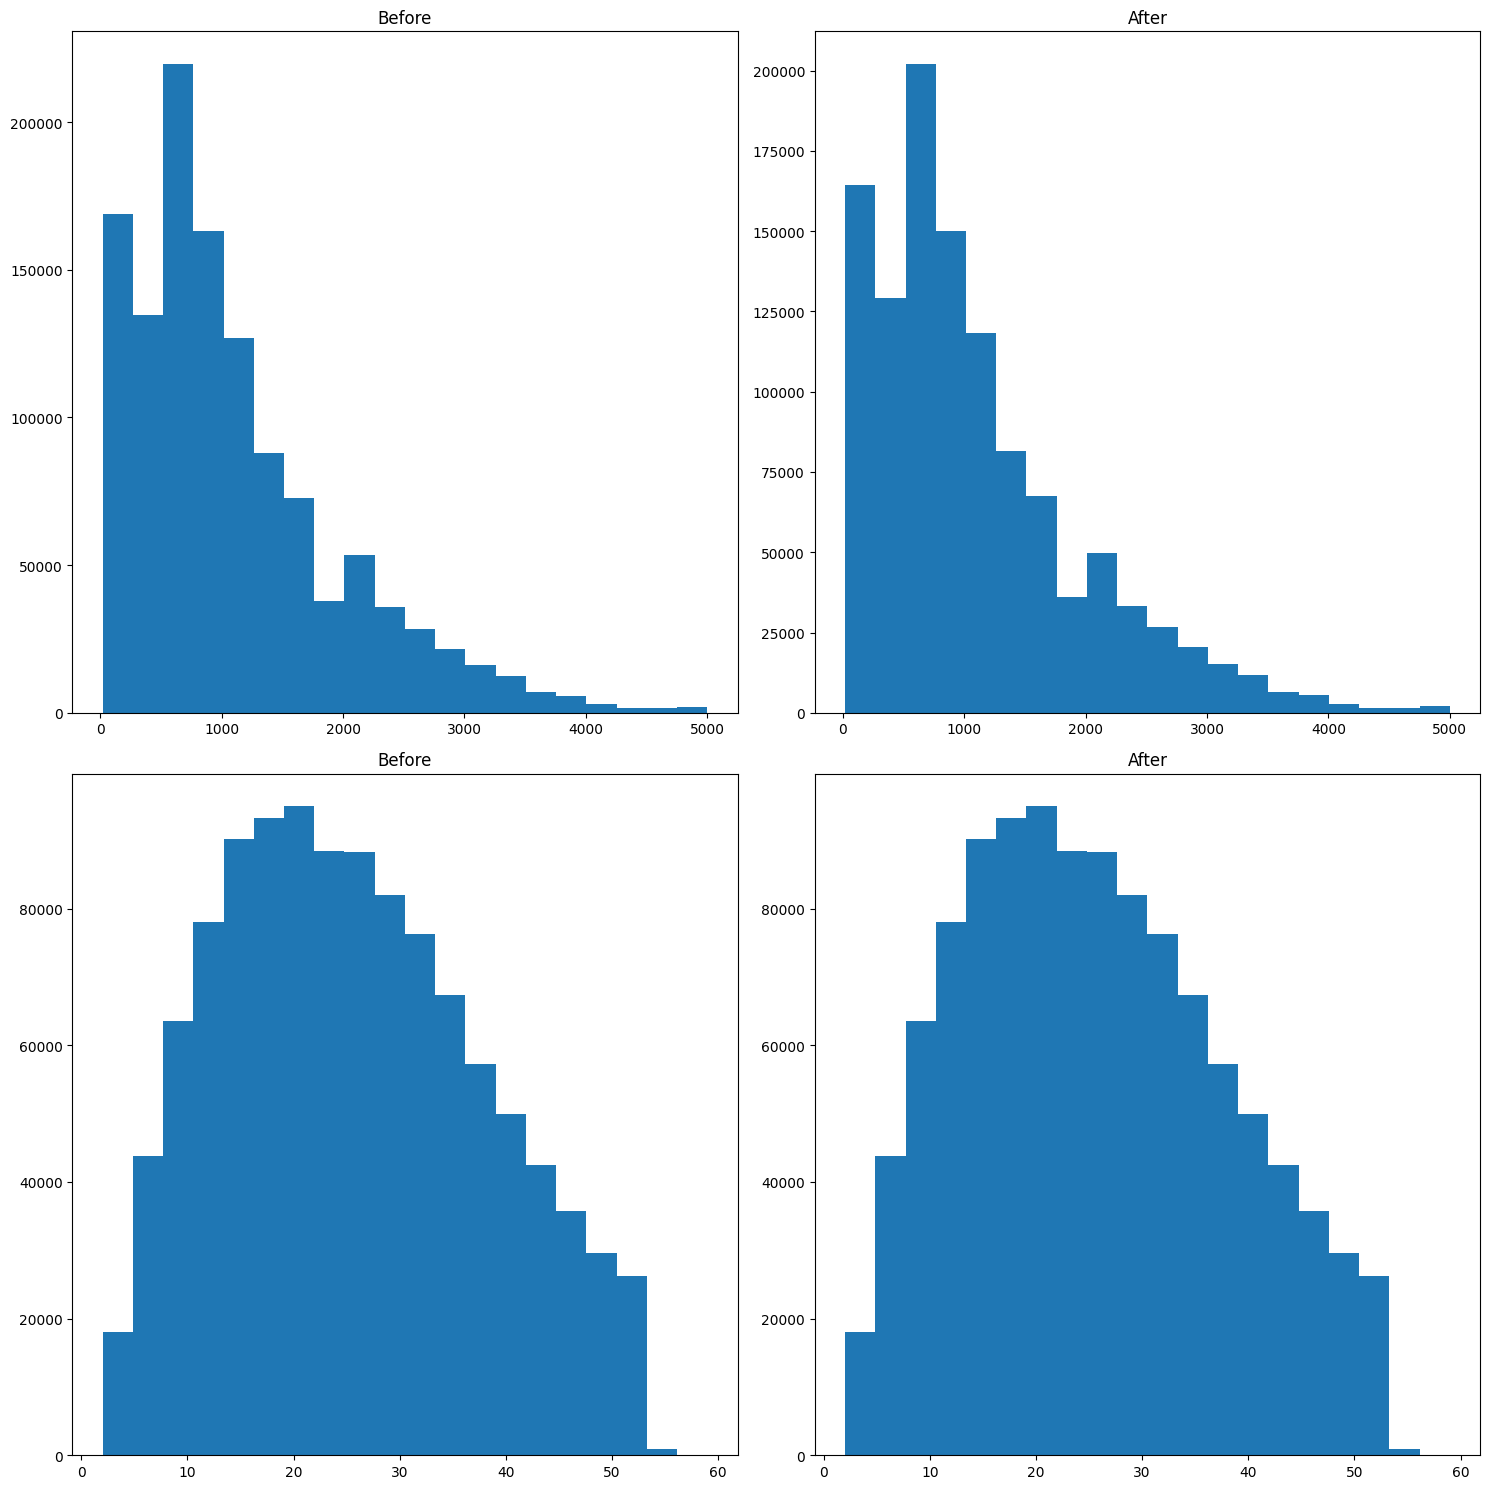

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.hist(x=data['Premium Amount'].values, bins=20)
plt.title('Before')

c = data[['Health Score', 'Premium Amount']]
c.dropna(inplace=True)
plt.subplot(222)
plt.hist(x=c[['Premium Amount']].values, bins=20)
plt.title('After')

plt.subplot(223)
plt.hist(x=data['Health Score'].values, bins=20)
plt.title('Before')

plt.subplot(224)
plt.hist(x=c[['Health Score']].values, bins=20)
plt.title('After')

plt.tight_layout()
plt.show()

<ipython-input-11-82807e90f186>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c.dropna(inplace=True)


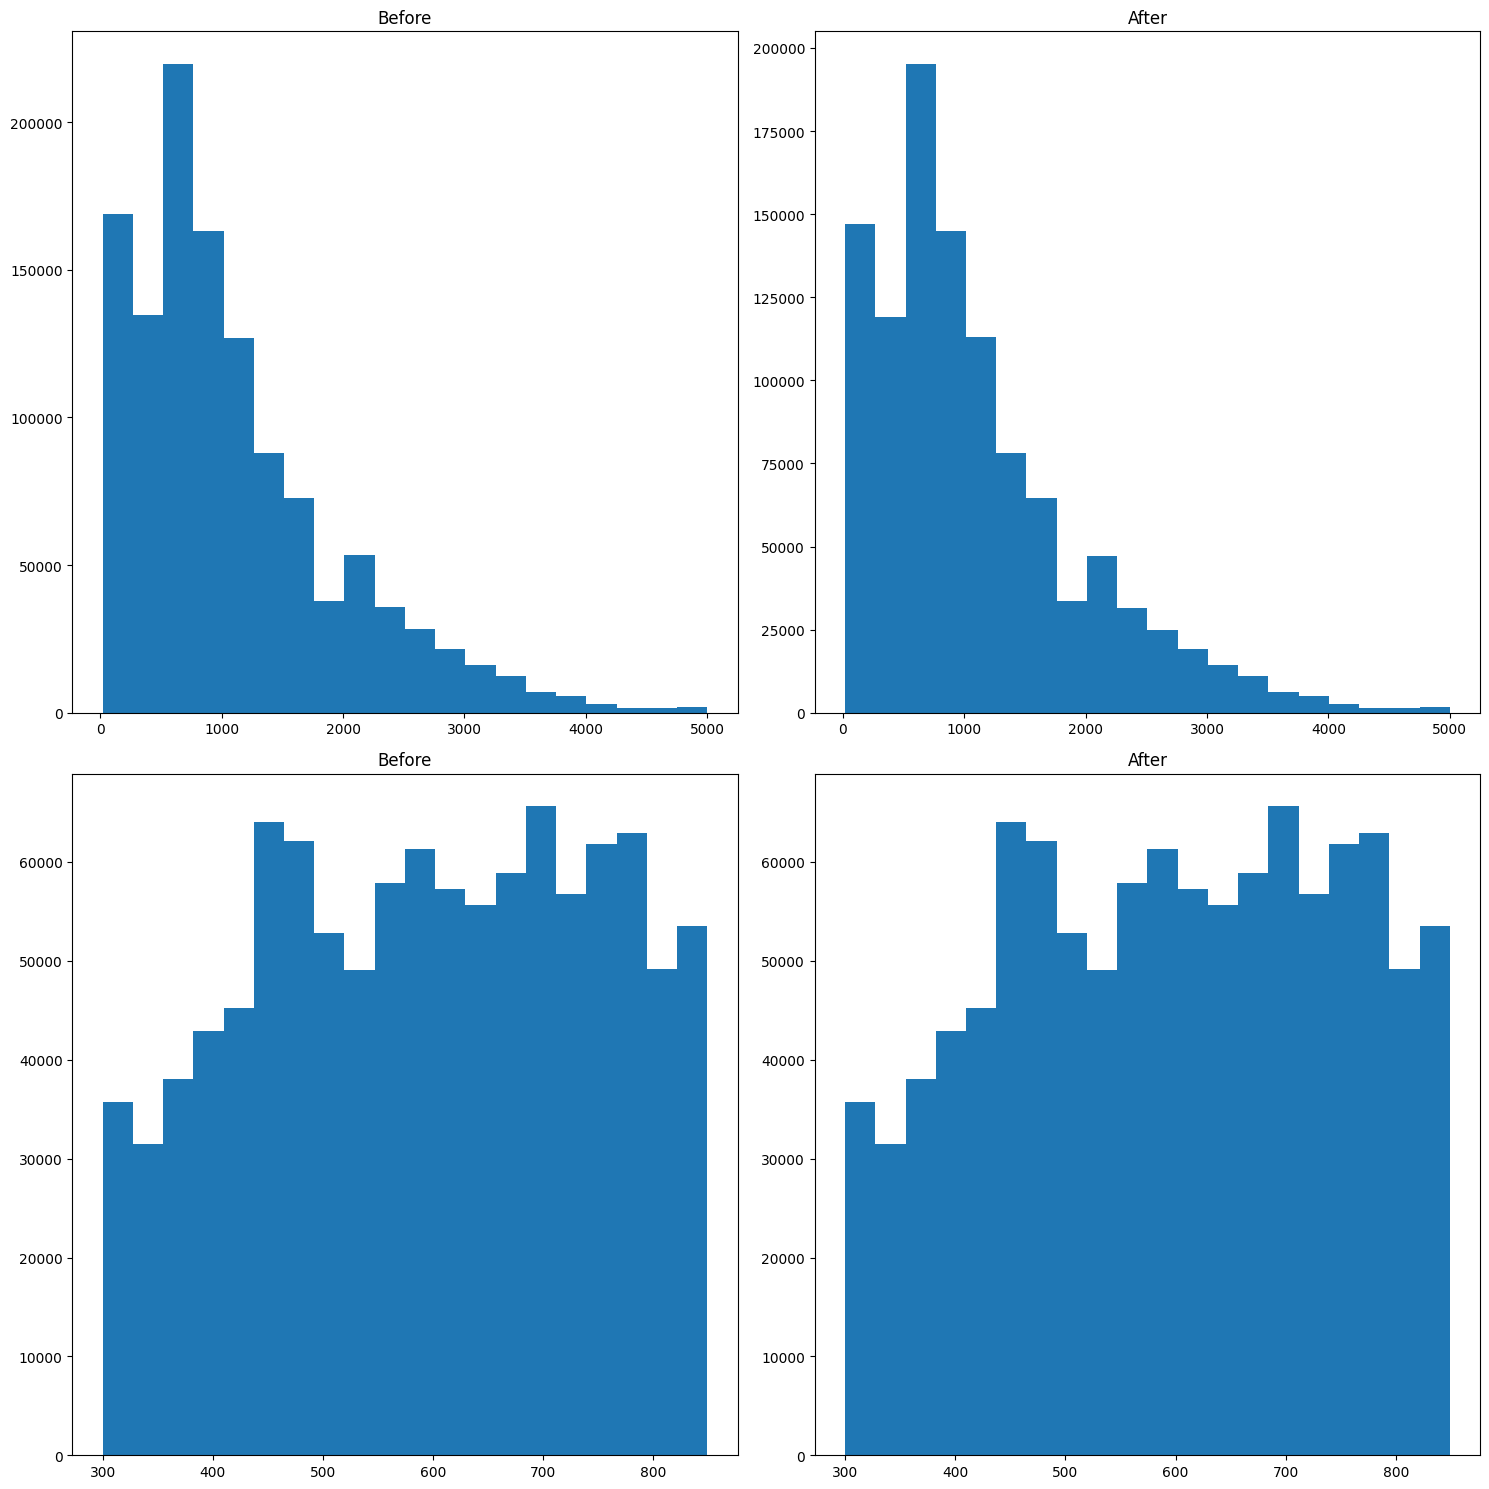

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.hist(x=data['Premium Amount'].values, bins=20)
plt.title('Before')

c = data[['Credit Score', 'Premium Amount']]
c.dropna(inplace=True)
plt.subplot(222)
plt.hist(x=c[['Premium Amount']].values, bins=20)
plt.title('After')

plt.subplot(223)
plt.hist(x=data['Credit Score'].values, bins=20)
plt.title('Before')

plt.subplot(224)
plt.hist(x=c[['Credit Score']].values, bins=20)
plt.title('After')

plt.tight_layout()
plt.show()

REMARKS: After age and Annual Incme deletion the distribution still intact, proofing that this is Missing at Completely Random (MCAR) case. Same thing happens with Age, Vehicle Age and Insurance Duration.

In [ ]:
data = data.dropna(subset=['Age', 'Annual Income', 'Vehicle Age', 'Insurance Duration'])
data.drop(columns='Number of Dependents', inplace=True)
data

<ipython-input-12-6290ac5f842b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns='Number of Dependents', inplace=True)


,Age,Gender,Annual Income,Marital Status,Education Level,Occupation,Health Score,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Smoking Status,Exercise Frequency,Property Type,Premium Amount,hours_since_epoch
0,19.0,Female,10049.0,Married,Bachelor's,Self-Employed,22.598761,Urban,Premium,17.0,372.0,5.0,No,Weekly,House,2869.0,473151
1,39.0,Female,31678.0,Divorced,Master's,NaN,15.569731,Rural,Comprehensive,12.0,694.0,2.0,Yes,Monthly,House,1483.0,468495
2,23.0,Male,25602.0,Divorced,High School,Self-Employed,47.177549,Suburban,Premium,14.0,NaN,3.0,Yes,Weekly,House,567.0,471135
3,21.0,Male,141855.0,Married,Bachelor's,NaN,10.938144,Rural,Basic,0.0,367.0,1.0,Yes,Daily,Apartment,765.0,477279
4,21.0,Male,39651.0,Single,Bachelor's,Self-Employed,20.376094,Rural,Premium,8.0,598.0,4.0,Yes,Weekly,House,2022.0,455103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199993,38.0,Male,1607.0,Married,High School,NaN,18.552314,Suburban,Comprehensive,12.0,469.0,2.0,No,Rarely,House,1027.0,461151
1199994,34.0,Male,23456.0,Single,Master's,Self-Employed,14.783439,Rural,Basic,12.0,548.0,9.0,No,Monthly,Apartment,1584.0,468423
1199995,36.0,Female,27316.0,Married,Master's,Unemployed,13.772907,Urban,Premium,5.0,372.0,3.0,No,Daily,Apartment,1303.0,467535
1199996,54.0,Male,35786.0,Divorced,Master's,Self-Employed,11.483482,Rural,Comprehensive,10.0,597.0,4.0,No,Weekly,Apartment,821.0,461895


We'll also fillna some missing values in the category features with 'unknown' so we can easily encode it later

In [ ]:
data['Marital Status'] = data['Marital Status'].fillna(value='Unknown')
data['Occupation'] = data['Occupation'].fillna(value='Unknown')
data

<ipython-input-13-5b3c21e1f19e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Marital Status'] = data['Marital Status'].fillna(value='Unknown')
<ipython-input-13-5b3c21e1f19e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Occupation'] = data['Occupation'].fillna(value='Unknown')


,Age,Gender,Annual Income,Marital Status,Education Level,Occupation,Health Score,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Smoking Status,Exercise Frequency,Property Type,Premium Amount,hours_since_epoch
0,19.0,Female,10049.0,Married,Bachelor's,Self-Employed,22.598761,Urban,Premium,17.0,372.0,5.0,No,Weekly,House,2869.0,473151
1,39.0,Female,31678.0,Divorced,Master's,Unknown,15.569731,Rural,Comprehensive,12.0,694.0,2.0,Yes,Monthly,House,1483.0,468495
2,23.0,Male,25602.0,Divorced,High School,Self-Employed,47.177549,Suburban,Premium,14.0,NaN,3.0,Yes,Weekly,House,567.0,471135
3,21.0,Male,141855.0,Married,Bachelor's,Unknown,10.938144,Rural,Basic,0.0,367.0,1.0,Yes,Daily,Apartment,765.0,477279
4,21.0,Male,39651.0,Single,Bachelor's,Self-Employed,20.376094,Rural,Premium,8.0,598.0,4.0,Yes,Weekly,House,2022.0,455103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199993,38.0,Male,1607.0,Married,High School,Unknown,18.552314,Suburban,Comprehensive,12.0,469.0,2.0,No,Rarely,House,1027.0,461151
1199994,34.0,Male,23456.0,Single,Master's,Self-Employed,14.783439,Rural,Basic,12.0,548.0,9.0,No,Monthly,Apartment,1584.0,468423
1199995,36.0,Female,27316.0,Married,Master's,Unemployed,13.772907,Urban,Premium,5.0,372.0,3.0,No,Daily,Apartment,1303.0,467535
1199996,54.0,Male,35786.0,Divorced,Master's,Self-Employed,11.483482,Rural,Comprehensive,10.0,597.0,4.0,No,Weekly,Apartment,821.0,461895


In [ ]:
data = data.dropna(subset=['Health Score'])
data = data.dropna(subset=['Credit Score'])
data

,Age,Gender,Annual Income,Marital Status,Education Level,Occupation,Health Score,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Smoking Status,Exercise Frequency,Property Type,Premium Amount,hours_since_epoch
0,19.0,Female,10049.0,Married,Bachelor's,Self-Employed,22.598761,Urban,Premium,17.0,372.0,5.0,No,Weekly,House,2869.0,473151
1,39.0,Female,31678.0,Divorced,Master's,Unknown,15.569731,Rural,Comprehensive,12.0,694.0,2.0,Yes,Monthly,House,1483.0,468495
3,21.0,Male,141855.0,Married,Bachelor's,Unknown,10.938144,Rural,Basic,0.0,367.0,1.0,Yes,Daily,Apartment,765.0,477279
4,21.0,Male,39651.0,Single,Bachelor's,Self-Employed,20.376094,Rural,Premium,8.0,598.0,4.0,Yes,Weekly,House,2022.0,455103
5,29.0,Male,45963.0,Married,Bachelor's,Unknown,33.053198,Urban,Premium,4.0,614.0,5.0,No,Weekly,House,3202.0,459183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199992,53.0,Female,6837.0,Married,High School,Self-Employed,17.844235,Urban,Comprehensive,15.0,406.0,4.0,No,Rarely,House,1251.0,447279
1199993,38.0,Male,1607.0,Married,High School,Unknown,18.552314,Suburban,Comprehensive,12.0,469.0,2.0,No,Rarely,House,1027.0,461151
1199994,34.0,Male,23456.0,Single,Master's,Self-Employed,14.783439,Rural,Basic,12.0,548.0,9.0,No,Monthly,Apartment,1584.0,468423
1199995,36.0,Female,27316.0,Married,Master's,Unemployed,13.772907,Urban,Premium,5.0,372.0,3.0,No,Daily,Apartment,1303.0,467535


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoders = {}
columns_to_encode = ['Gender', 'Smoking Status', 'Education Level', 'Policy Type', 'Exercise Frequency', 'Marital Status', 'Occupation',]

for col in columns_to_encode:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le  # Save the encoder

data = pd.get_dummies(data, columns=['Location','Property Type'])
data.reset_index(drop=True)

,Age,Gender,Annual Income,Marital Status,Education Level,Occupation,Health Score,Policy Type,Vehicle Age,Credit Score,...,Smoking Status,Exercise Frequency,Premium Amount,hours_since_epoch,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House
0,19.0,0,10049.0,1,0,1,22.598761,2,17.0,372.0,...,0,3,2869.0,473151,False,False,True,False,False,True
1,39.0,0,31678.0,0,2,3,15.569731,1,12.0,694.0,...,1,1,1483.0,468495,True,False,False,False,False,True
2,21.0,1,141855.0,1,0,3,10.938144,0,0.0,367.0,...,1,0,765.0,477279,True,False,False,True,False,False
3,21.0,1,39651.0,2,0,1,20.376094,2,8.0,598.0,...,1,3,2022.0,455103,True,False,False,False,False,True
4,29.0,1,45963.0,1,0,3,33.053198,2,4.0,614.0,...,0,3,3202.0,459183,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943185,53.0,0,6837.0,1,1,1,17.844235,1,15.0,406.0,...,0,2,1251.0,447279,False,False,True,False,False,True
943186,38.0,1,1607.0,1,1,3,18.552314,1,12.0,469.0,...,0,2,1027.0,461151,False,True,False,False,False,True
943187,34.0,1,23456.0,2,2,1,14.783439,0,12.0,548.0,...,0,1,1584.0,468423,True,False,False,True,False,False
943188,36.0,0,27316.0,1,2,2,13.772907,2,5.0,372.0,...,0,0,1303.0,467535,False,False,True,True,False,False


In [ ]:
data.drop(columns=['Policy Type','Insurance Duration'], inplace=True)

In [ ]:
#let's check if we stil have any NaN's
data.isnull().sum()

,0
Age,0
Gender,0
Annual Income,0
Marital Status,0
Education Level,0
Occupation,0
Health Score,0
Vehicle Age,0
Credit Score,0
Smoking Status,0


It turns out we have outliers in the Annual Income, but we will delete it per 1USD increment in Premium Amount. If we observed closely on the Boxplot below, for Premium Amount 20-21 USD, there are huge variety in Annual Income. Some of them are outliers and this will add noises to the data, so we'll eliminate them in every 1USD range of Premium Amount.

<Axes: ylabel='Annual Income'>

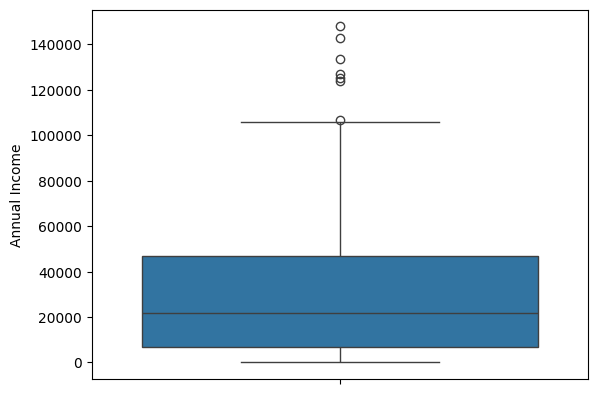

In [ ]:
low_rng = 20
upr_rng = 21

data_cut = data.loc[(data['Premium Amount'] > low_rng) & (data['Premium Amount'] <= upr_rng), :]
sns.boxplot(data=data_cut['Annual Income'])

In [ ]:
def clean_all_outliers_by_bin(df, target_col='Annual Income', bin_col='Premium Amount'):
    df['PremiumBin'] = df[bin_col].astype(int)

    def clean_bin(group):
        previous_len = -1
        current = group.copy()
        # Keep cleaning until no change
        while len(current) != previous_len:
            previous_len = len(current)
            current = outlier_fx(current, target_col)
        return current

    # Apply cleaning per bin
    df = df.groupby('PremiumBin', group_keys=False).apply(clean_bin)
    return df.drop(columns=['PremiumBin'])

# Usage:
data = clean_all_outliers_by_bin(data)
data

<ipython-input-19-d5d2a952d22c>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('PremiumBin', group_keys=False).apply(clean_bin)


,Age,Gender,Annual Income,Marital Status,Education Level,Occupation,Health Score,Vehicle Age,Credit Score,Smoking Status,Exercise Frequency,Premium Amount,hours_since_epoch,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House
676,25.0,0,92648.0,2,3,3,32.184862,5.0,449.0,1,3,20.0,465135,False,True,False,True,False,False
2685,55.0,1,3858.0,2,3,0,25.865345,7.0,694.0,1,3,20.0,477975,False,True,False,False,True,False
2951,64.0,1,56786.0,0,1,2,16.054946,2.0,494.0,0,3,20.0,456351,False,False,True,True,False,False
3184,23.0,1,5881.0,2,0,2,7.048325,7.0,726.0,0,0,20.0,471087,True,False,False,True,False,False
3236,58.0,1,10924.0,1,1,3,3.294094,16.0,581.0,1,0,20.0,476871,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75643,52.0,0,23435.0,2,2,0,13.285972,15.0,340.0,0,0,4994.0,453999,False,False,True,True,False,False
1169248,62.0,0,8440.0,1,2,2,21.997465,1.0,581.0,1,0,4996.0,438375,False,False,True,True,False,False
767167,51.0,1,38988.0,0,1,2,26.002469,10.0,778.0,1,2,4997.0,442791,True,False,False,False,True,False
877994,26.0,0,79801.0,2,2,2,19.739327,5.0,571.0,1,3,4997.0,451407,True,False,False,True,False,False


## EDA: INITIAL CORRELATION CHECK
Now that we have cleaned everything, let's dive down into all relations between each features. We first plot correlation heatmap.

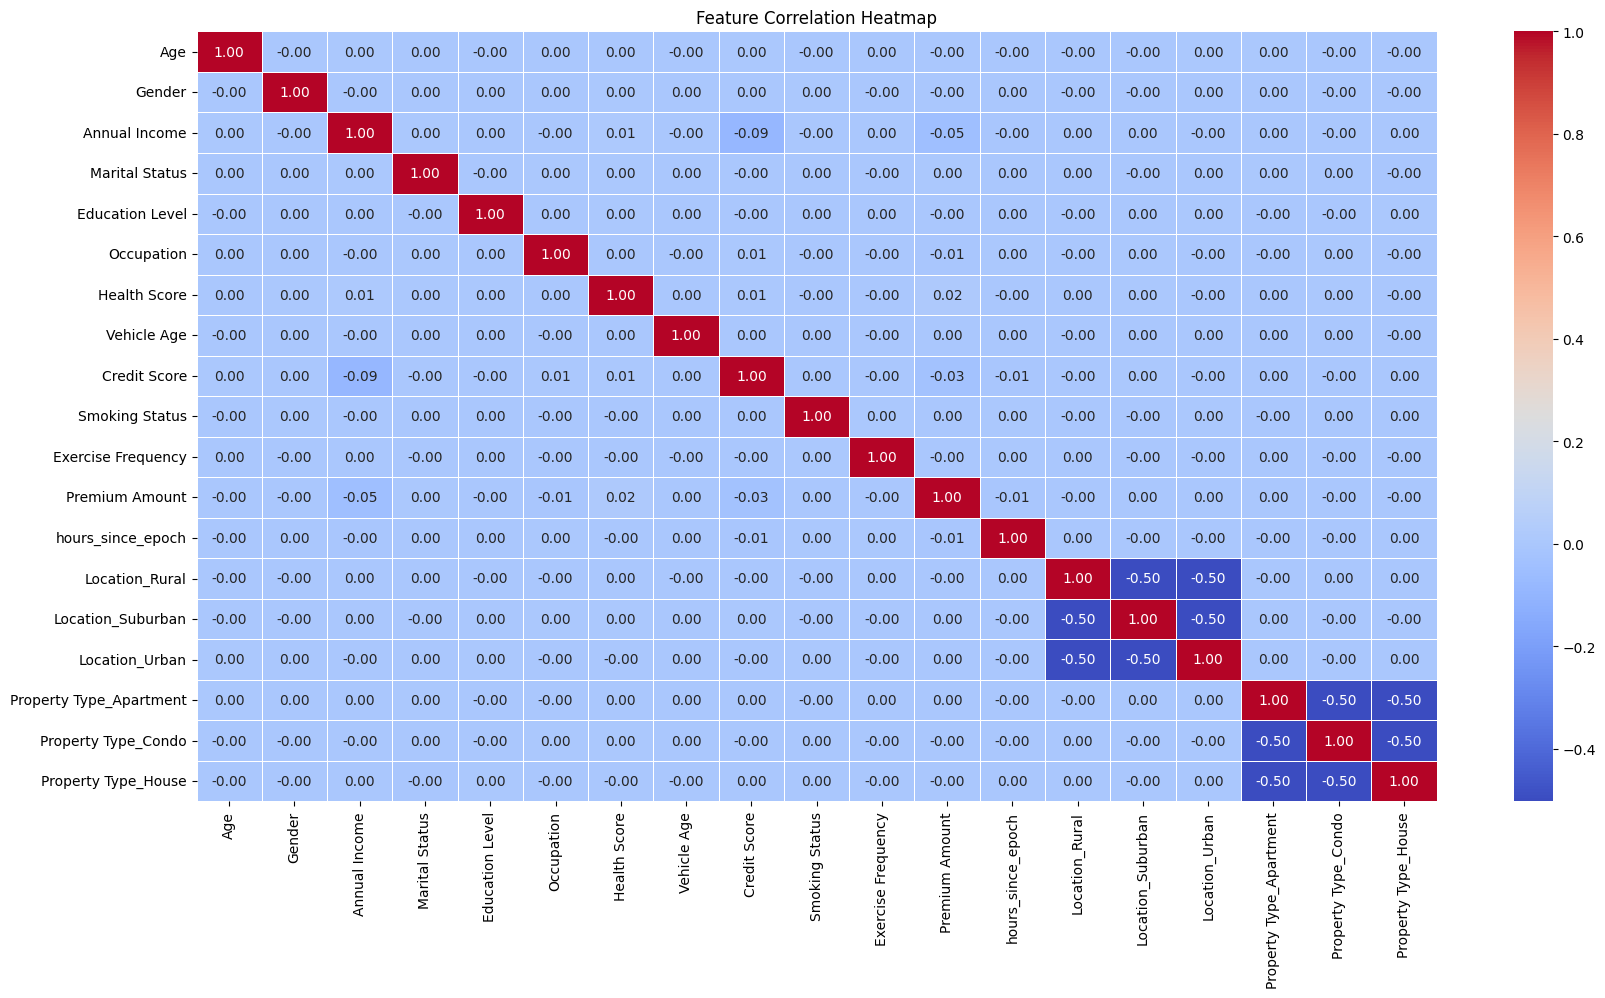

In [ ]:
corr_matrix = data.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

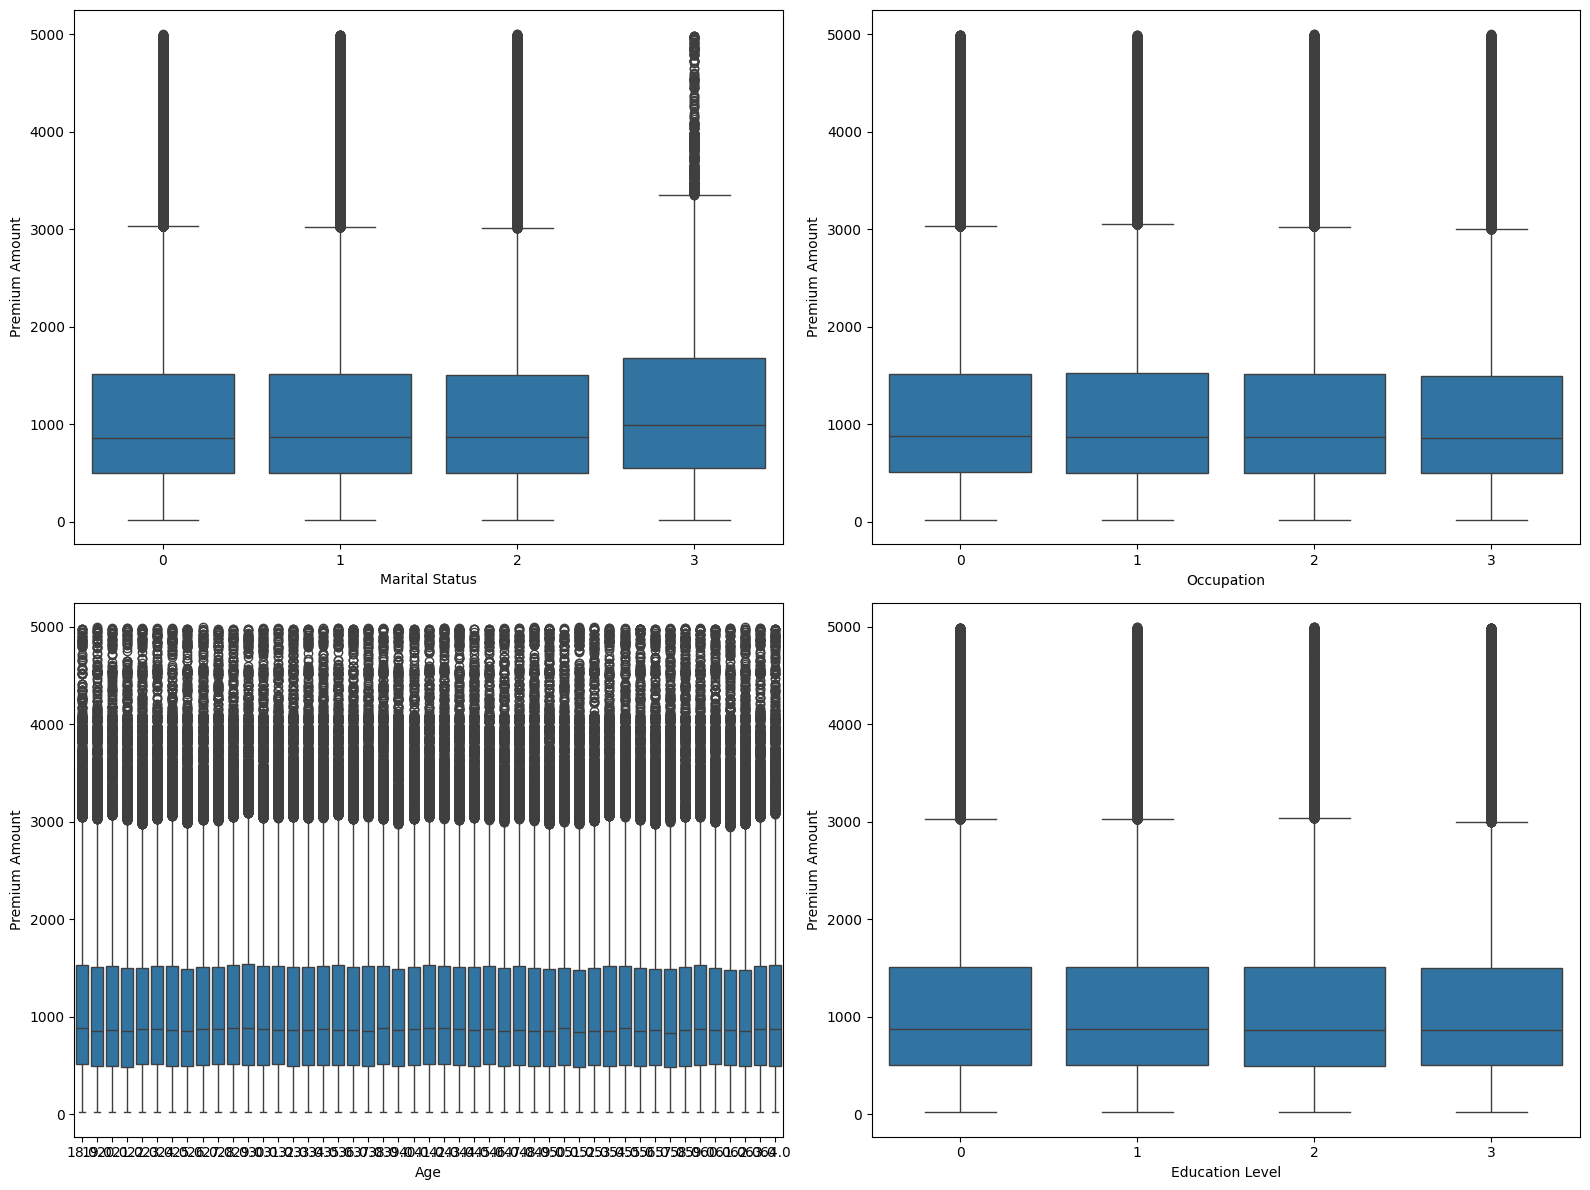

In [ ]:
plt.figure(figsize=(16,12))
plt.subplot(221)
sns.boxplot(data=data, x='Marital Status', y='Premium Amount')
plt.subplot(222)
sns.boxplot(data=data, x='Occupation', y='Premium Amount')
plt.subplot(223)
sns.boxplot(data=data, x='Age', y='Premium Amount')
plt.subplot(224)
sns.boxplot(data=data, x='Education Level', y='Premium Amount')
plt.tight_layout()
plt.show()

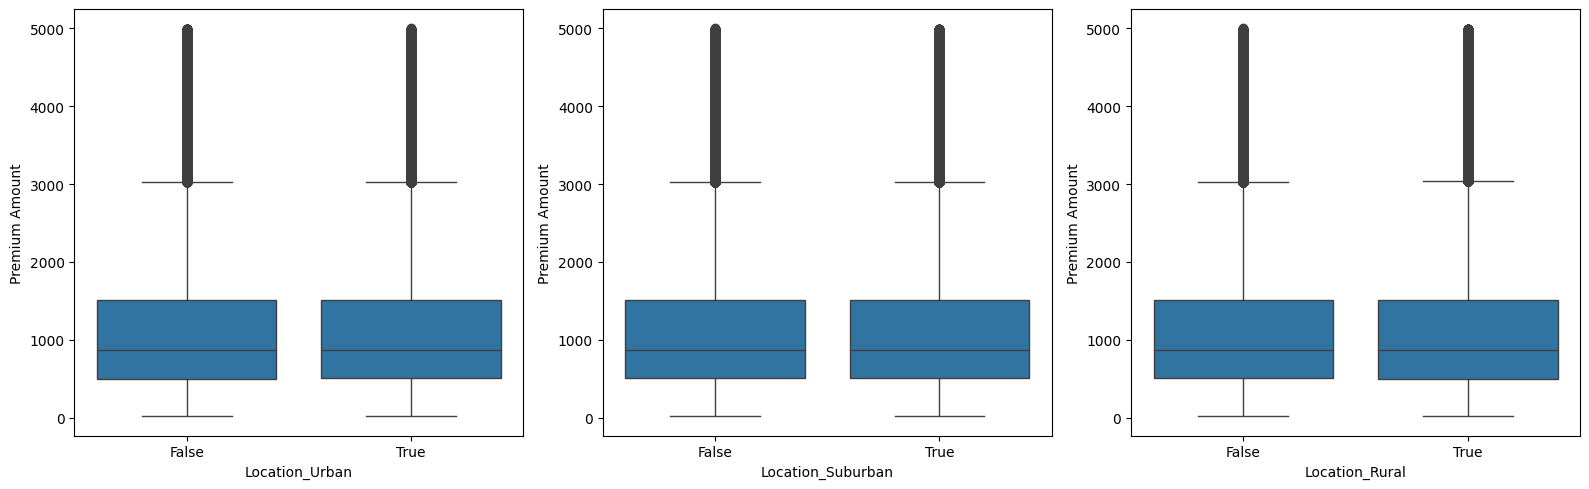

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(131)
sns.boxplot(data=data, x='Location_Urban', y='Premium Amount')
plt.subplot(132)
sns.boxplot(data=data, x='Location_Suburban', y='Premium Amount')
plt.subplot(133)
sns.boxplot(data=data, x='Location_Rural', y='Premium Amount')
plt.tight_layout()
plt.show()

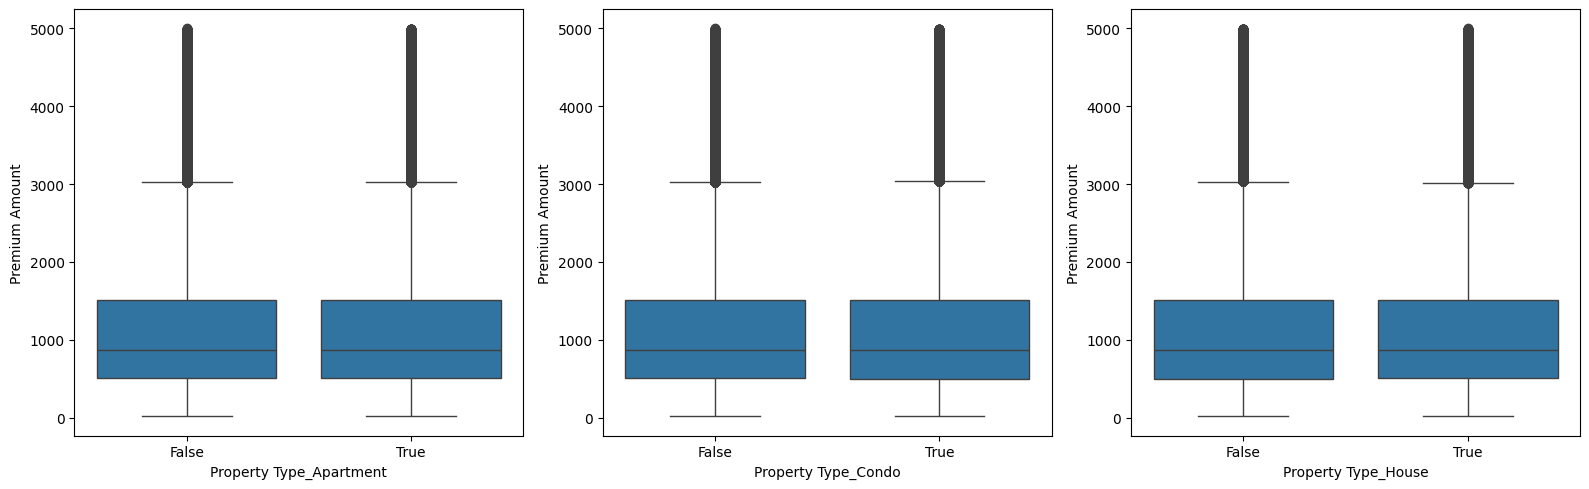

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(131)
sns.boxplot(data=data, x='Property Type_Apartment', y='Premium Amount')
plt.subplot(132)
sns.boxplot(data=data, x='Property Type_Condo', y='Premium Amount')
plt.subplot(133)
sns.boxplot(data=data, x='Property Type_House', y='Premium Amount')
plt.tight_layout()
plt.show()

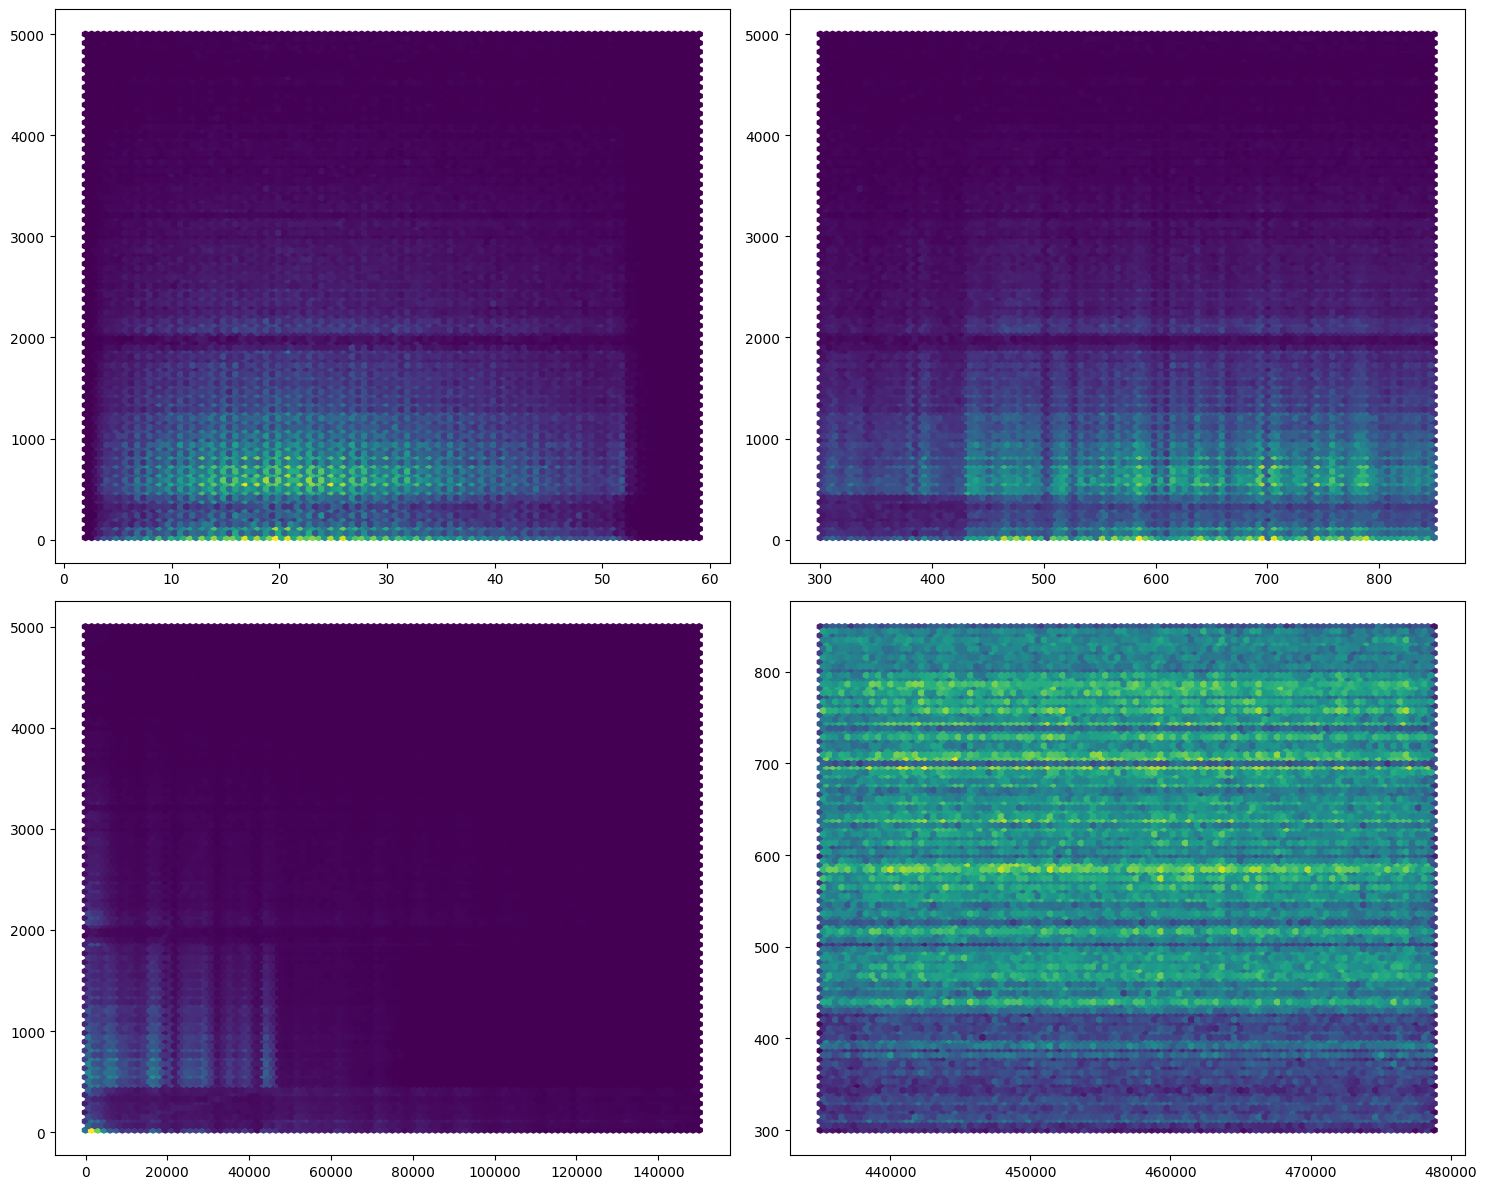

In [ ]:
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.hexbin(x=data['Health Score'], y=data['Premium Amount'])
plt.subplot(222)
plt.hexbin(x=data['Credit Score'], y=data['Premium Amount'])
plt.subplot(223)
plt.hexbin(x=data['Annual Income'], y=data['Premium Amount'])
plt.subplot(224)
plt.hexbin(x=data['hours_since_epoch'], y=data['Credit Score'])
plt.tight_layout()
plt.show()

REMARKS: It is evident from the data that lots of features doen't have good variation with the features target. Not only the target, they also lack of correlation with each other.

### Feature Engineering
If we take a closer observation between Premium Amount and Annual Income we'll notice strange patterns in where people with high annual income invest in small Premium amount (e.g. people with 90k USD annual income gives only 20 USD premium amount or people with only 3016 USD annual income invest in 3012 USD premium amount-what do you eat after you pay the premium??)

THerefore, we'll look some references and see what is the normal ratio of Premium Amount vs Annual Income, some reference said that the normal range are between 5-10%, and some said that 6% is the normal value. We'll just take 2-6% range and see the accuracy of the Machine Learning model from there.

We'll also create some feature engineering in some prospect feature like Age vs Income, Health score vs Income to increase signal in respect to Premium Amount. We'll also make flagging FE and give risk flag based on credit score vs income, health score vs smoking behaviour and exercisee frequency, occupation type vs annual income. All these to boost the signal correlations in respect to Premium Amount.

For the time being we'll leave the risk relationship based on marriage status vs annual income, or place of living vs annual income, or type of property vs credit score and annual income. All of these features have low correlations anyway but might worth to be explored later.

REFERENCES:
1. https://www.guardianlife.com/life-insurance/how-much-life-insurance-do-you-need
2. https://www.deccanherald.com/business/what-percentage-of-your-income-should-be-reserved-for-insurance-1146226.html

In [ ]:
original_values = encoders['Occupation'].classes_
original_values

array(['Employed', 'Self-Employed', 'Unemployed', 'Unknown'], dtype=object)

In [ ]:
data.reset_index(drop=True, inplace=True)
# data['Credit_Income'] = data['Annual Income'] * (data['Credit Score']**2)
data['Health_Income'] = np.log1p((data['Annual Income'] / 1000) + data['Health Score'])
data['Age_Income'] = np.log1p((data['Annual Income'] / 1000) + data['Age'])
# data['log_premium_amount'] = np.log1p(data['Premium Amount'])
data["premium_income_ratio"] = data["Premium Amount"] / data["Annual Income"]
data = data.loc[(data["premium_income_ratio"] >= 0.02) & (data["premium_income_ratio"] <= 0.06), :]

credit_risk = []
for i in range(len(data['Annual Income'])):
  if data['Smoking Status'][i] <= 50000 and data['Credit Score'][i] <= 500:
    credit_risk.append(3)
  elif data['Annual Income'][i] > 50000 and data['Credit Score'][i] <= 500:
    credit_risk.append(2)
  elif data['Annual Income'][i] <= 50000 and data['Credit Score'][i] > 500:
    credit_risk.append(1)
  elif data['Annual Income'][i] > 50000 and data['Credit Score'][i] > 500:
    credit_risk.append(0)
data['credit_risk'] = credit_risk

health_risk = []
for i in range(len(data['Health Score'])):
  if data['Exercise Frequency'][i] == 0:
    if data['Smoking Status'][i] == 0:
      if data['Health Score'][i] > 50:
        health_risk.append(0)
      elif data['Health Score'][i] <= 50:
        health_risk.append(1)
    elif data['Smoking Status'][i] == 1:
      if data['Health Score'][i] > 50:
        health_risk.append(2)
      elif data['Health Score'][i] <= 50:
        health_risk.append(3)
  elif data['Exercise Frequency'][i] == 3:
    if data['Smoking Status'][i] == 0:
      if data['Health Score'][i] > 50:
        health_risk.append(4)
      elif data['Health Score'][i] <= 50:
        health_risk.append(5)
    elif data['Smoking Status'][i] == 1:
      if data['Health Score'][i] > 50:
        health_risk.append(6)
      elif data['Health Score'][i] <= 50:
        health_risk.append(7)
  elif data['Exercise Frequency'][i] == 1:
    if data['Smoking Status'][i] == 0:
      if data['Health Score'][i] > 50:
        health_risk.append(8)
      elif data['Health Score'][i] <= 50:
        health_risk.append(9)
    elif data['Smoking Status'][i] == 1:
      if data['Health Score'][i] > 50:
        health_risk.append(10)
      elif data['Health Score'][i] <= 50:
        health_risk.append(11)
  elif data['Exercise Frequency'][i] == 2:
    if data['Smoking Status'][i] == 0:
      if data['Health Score'][i] > 50:
        health_risk.append(12)
      elif data['Health Score'][i] <= 50:
        health_risk.append(13)
    elif data['Smoking Status'][i] == 1:
      if data['Health Score'][i] > 50:
        health_risk.append(14)
      elif data['Health Score'][i] <= 50:
        health_risk.append(15)
data['health_risk'] = health_risk

occupation_risk = []
for i in range(len(data['Occupation'])):
  if data['Occupation'][i] == 0:
    if data['Annual Income'][i] > 50000:
      occupation_risk.append(0)
    elif data['Annual Income'][i] <= 50000:
      occupation_risk.append(1)
  elif data['Occupation'][i] == 1:
    if data['Annual Income'][i] > 50000:
      occupation_risk.append(2)
    elif data['Annual Income'][i] <= 50000:
      occupation_risk.append(3)
  elif data['Occupation'][i] == 2:
    if data['Annual Income'][i] > 50000:
      occupation_risk.append(4)
    elif data['Annual Income'][i] <= 50000:
      occupation_risk.append(5)
  elif data['Occupation'][i] == 3:
    if data['Annual Income'][i] > 50000:
      occupation_risk.append(6)
    elif data['Annual Income'][i] <= 50000:
      occupation_risk.append(7)
data['occupation_risk'] = occupation_risk

data

<ipython-input-27-fc30f3811fa9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Health_Income'] = np.log1p((data['Annual Income'] / 1000) + data['Health Score'])
<ipython-input-27-fc30f3811fa9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age_Income'] = np.log1p((data['Annual Income'] / 1000) + data['Age'])
<ipython-input-27-fc30f3811fa9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,Age,Gender,Annual Income,Marital Status,Education Level,Occupation,Health Score,Vehicle Age,Credit Score,Smoking Status,...,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House,Health_Income,Age_Income,premium_income_ratio,credit_risk,health_risk,occupation_risk
0,18.0,1,728.0,2,3,3,23.845244,9.0,642.0,0,...,False,False,False,True,3.241547,2.982039,0.027473,1,9,7
1,21.0,0,439.0,2,3,0,18.958274,2.0,578.0,1,...,False,True,False,False,3.015401,3.110801,0.045558,1,15,1
2,56.0,0,935.0,2,3,0,30.891523,5.0,849.0,1,...,True,True,False,False,3.491237,4.059322,0.021390,1,15,1
3,51.0,1,618.0,0,0,2,41.828773,5.0,558.0,0,...,False,True,False,False,3.771537,3.963058,0.032362,1,9,5
4,57.0,0,749.0,2,1,3,32.366658,17.0,515.0,1,...,True,False,False,True,3.529756,4.073274,0.026702,1,11,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294549,58.0,1,100038.0,2,2,3,24.010778,14.0,312.0,0,...,False,False,False,True,4.828704,5.069143,0.049861,3,13,6
294550,20.0,1,100038.0,2,0,2,24.010778,6.0,344.0,1,...,False,False,False,True,4.828704,4.796105,0.049861,3,7,4
294551,49.0,0,100038.0,0,2,0,24.010778,10.0,344.0,0,...,False,False,False,True,4.828704,5.010889,0.049861,3,5,0
294552,61.0,1,100038.0,2,1,1,24.010778,5.0,344.0,0,...,False,True,False,False,4.828704,5.087831,0.049861,3,1,2


In [ ]:
data.drop(columns=['Gender', 'Smoking Status',
                  'Exercise Frequency', 'Occupation', 'Education Level', 'Marital Status'], inplace=True)

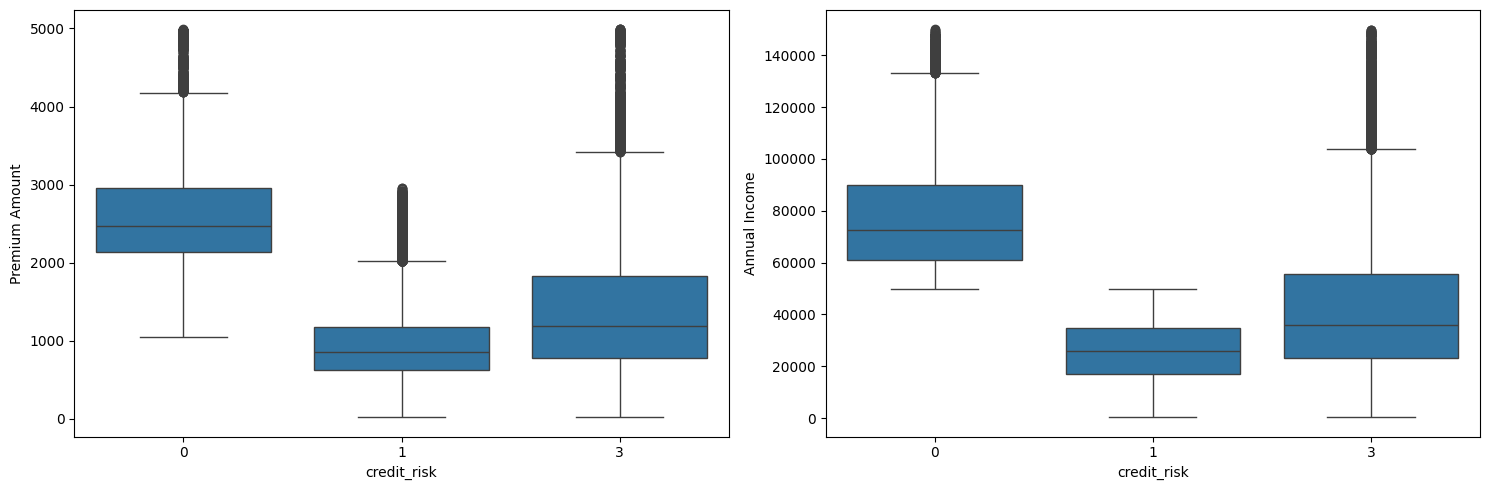

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(data=data, x='credit_risk', y='Premium Amount')
plt.subplot(122)
sns.boxplot(data=data, x='credit_risk', y='Annual Income')
plt.tight_layout()
plt.show()

## FEATURE SELECTION

Before we do modelling with Machine Learning, we'll do feature selection based on final correlation check. We'll discard low signal features.

In [ ]:
corr_check = data.corr(method='pearson')['Premium Amount'].sort_values(ascending=False)
corr_check

,Premium Amount
Premium Amount,1.000000
Annual Income,0.851146
Health_Income,0.687539
Age_Income,0.667717
premium_income_ratio,0.207367
credit_risk,0.034733
Health Score,0.027808
Location_Suburban,0.002426
Property Type_Condo,0.001962
Vehicle Age,0.001476


In [ ]:
eliminate_features = []
for i in range(len(corr_check)):
  if corr_check[i] < 0.05 and corr_check[i] > -0.05:
    eliminate_features.append(corr_check.keys()[i])

eliminate_features

<ipython-input-31-e4ad00456e78>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if corr_check[i] < 0.05 and corr_check[i] > -0.05:


['credit_risk',
 'Health Score',
 'Location_Suburban',
 'Property Type_Condo',
 'Vehicle Age',
 'Property Type_Apartment',
 'Location_Rural',
 'health_risk',
 'Age',
 'Property Type_House',
 'Location_Urban',
 'hours_since_epoch']

In [ ]:
eliminate_features.remove('health_risk')
eliminate_features.remove('credit_risk')
data.drop(columns=eliminate_features, inplace=True)
data

,Annual Income,Credit Score,Premium Amount,Health_Income,Age_Income,premium_income_ratio,credit_risk,health_risk,occupation_risk
0,728.0,642.0,20.0,3.241547,2.982039,0.027473,1,9,7
1,439.0,578.0,20.0,3.015401,3.110801,0.045558,1,15,1
2,935.0,849.0,20.0,3.491237,4.059322,0.021390,1,15,1
3,618.0,558.0,20.0,3.771537,3.963058,0.032362,1,9,5
4,749.0,515.0,20.0,3.529756,4.073274,0.026702,1,11,7
...,...,...,...,...,...,...,...,...,...
294549,100038.0,312.0,4988.0,4.828704,5.069143,0.049861,3,13,6
294550,100038.0,344.0,4988.0,4.828704,4.796105,0.049861,3,7,4
294551,100038.0,344.0,4988.0,4.828704,5.010889,0.049861,3,5,0
294552,100038.0,344.0,4988.0,4.828704,5.087831,0.049861,3,1,2


## MACHINE MODELLING STEP
We'll use `RandomForestRegressor`, `GradientBoostingRegressor`, and `XGBRegressor` to predict the Premium Amount value and compare which one is the best

In [ ]:
# label_id = []

# for i in data_mock['Premium Amount'].values:
#   if i <= 2500:
#     label_id.append(0)
#   elif i > 2500:
#     label_id.append(1)

# data_mock['label_id'] = label_id

In [ ]:
# model_bins = {}
# model_bins_main = {}
# # scaler = MinMaxScaler()
# scaler_knn = MinMaxScaler()
# scaler_gm = MinMaxScaler()
# scaler = StandardScaler()

# features = [col for col in data_mock.columns if (col != 'Premium Amount') and (col != 'label_id')]
# scaler_knn.fit(data_mock[features])
# # scaler_knn.fit(data_mock[['Annual Income']])

# def gatingMechanism(datasets):
#     x_subset = datasets.drop(columns=['Premium Amount', 'label_id'])
#     y_subset = datasets['Premium Amount']

#     # x_subset_scaled = scaler.transform(x_subset)
#     x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(
#         x_subset, y_subset, test_size=0.3, random_state=42)

#     print(f'Testing model in progress.')
#     lin_reg = RandomForestRegressor(n_estimators=100, max_depth=30, verbose=1, random_state=42)
#     # lin_reg = LinearRegression(copy_X=True)
#     lin_reg.fit(x_train_sub, y_train_sub)
#     y_pred_sub = lin_reg.predict(x_test_sub)

#     print('Here are the machine learning testing result: ')
#     rmse_score = root_mean_squared_error(y_test_sub, y_pred_sub)
#     mape_score = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
#     print(f'rmse_score: {rmse_score}, mape_score is: {mape_score}')

#     range_set = str(round(datasets['Premium Amount'].min())) + '-' + str(round(datasets['Premium Amount'].max()))
#     data_range = round(datasets['Premium Amount'].max()) - round(datasets['Premium Amount'].min())
#     lowest_rng = round(datasets['Premium Amount'].min())
#     print(f'Inserting database {range_set} into dictionaries.')
#     model_bins[range_set] = lin_reg, data_range, lowest_rng
#     print('Succesfully add model to dictionaries.\n')

# def findCenterMass(datasets):
#     features_cm = [i for i in datasets.columns if (i != 'Premium Amount') and (i != 'label_id')]
#     scaled_features = scaler_knn.transform(datasets[features_cm])
#     center_mass = np.mean(scaled_features, axis=0)
#     return center_mass

# def modelLearner(datasets):
#     print(f'Fitting models through learn datasets.')
#     count_upper = 2500
#     count_lower = 0
#     ctr = 0

#     while count_upper <= 5000:
#         print(f'lower limit is: {count_lower}, upper limit is: {count_upper}')
#         data_mo = datasets.loc[(datasets['Premium Amount'] > count_lower) & (datasets['Premium Amount'] <= count_upper)]
#         data_mo.reset_index(inplace=True, drop=True)
#         print(f'We will process approximately: {len(data_mo)} instances')

#         X = data_mo.drop(columns=['Premium Amount', 'label_id'])
#         y = data_mo['Premium Amount']
#         # y_log = np.log1p(y)

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#         # X_train_scaled = scaler.fit_transform(X_train)
#         # X_test_scaled = scaler.transform(X_test)

#         # pca = PCA(n_components=0.95, random_state=42)
#         # X_train_pca = pca.fit_transform(X_train_scaled)
#         # X_test_pca = pca.transform(X_test_scaled)
#         # print(f"Original feature count: {X.shape[1]}")
#         # print(f"Reduced feature count after PCA: {X_train_pca.shape[1]}")

#         model = RandomForestRegressor(n_estimators=100, max_depth=25,
#                                   random_state=42, verbose=2)
#         model.fit(X_train, y_train)

#         y_pred = model.predict(X_test)
#         # y_pred = np.expm1(y_pred_log)  # inverse of log1p
#         # y_test_original = np.expm1(y_test)
#         y_test_original = y_test

#         if(count_upper <= 2500):
#             y_smoothed = lowess(endog=y_test_original, exog=y_pred,
#             frac=0.1, return_sorted=False)

#             rmse_score = root_mean_squared_error(y_test_original, y_smoothed)
#             mape_score = mean_absolute_percentage_error(y_test_original, y_smoothed)
#             mae_score = mean_absolute_error(y_test_original, y_smoothed)
#             rmsle_score = root_mean_squared_log_error(y_test_original, y_smoothed)
#             relative_mae = mae_score / np.mean(y_test_original)
#             print(f'smoothed relative mae score: {relative_mae}')
#             print(f'smoothed rmse score: {rmse_score}, smoothed mape score: {mape_score}')
#             print(f'smoothed mae score: {mae_score}, smoothed rmsle score: {rmsle_score}')

#         elif(count_upper > 2500):
#             residual = y_test_original - y_pred
#             residual_smoothed = lowess(residual, y_pred, frac=0.1, return_sorted=False)
#             y_smoothed = y_pred + residual_smoothed

#             rmse_score = root_mean_squared_error(y_test_original, y_smoothed)
#             mape_score = mean_absolute_percentage_error(y_test_original, y_smoothed)
#             mae_score = mean_absolute_error(y_test_original, y_smoothed)
#             rmsle_score = root_mean_squared_log_error(y_test_original, y_smoothed)
#             relative_mae = mae_score / np.mean(y_test_original)
#             print(f'relative mae score: {relative_mae}')
#             print(f'rmse score: {rmse_score}, mape score: {mape_score}')
#             print(f'mae score: {mae_score}, rmsle score: {rmsle_score}')

#         count_lower = count_upper
#         count_upper += 2500
#         model_bins_main[ctr] = model
#         print(f'Succesfully add model no {ctr} to dictionaries model_bins_main.\n')
#         ctr += 1


# # split data_mock so you have 10 percent for testing and 90 percent will be used to train
# data_mock_main, data_mock_train = train_test_split(data_mock, test_size=0.2, random_state=42)
# rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, verbose=1, random_state=42)
# rf_clf.fit(data_mock_main[features], data_mock_main['label_id'])

# # Separate data_mock into 4 ranges with range of 1250
# # dict_datasets = {
# #     1 : data_mock_main.loc[(data_mock_main['Premium Amount'] <= 1250), :],
# #     2 : data_mock_main.loc[(data_mock_main['Premium Amount'] > 1250) & (data_mock_main['Premium Amount'] <= 2500), :],
# #     3 : data_mock_main.loc[(data_mock_main['Premium Amount'] > 2500) & (data_mock_main['Premium Amount'] <= 3750), :],
# #     4 : data_mock_main.loc[(data_mock_main['Premium Amount'] > 3750)]
# # }
# dict_datasets = {1 : data_mock_main.loc[(data_mock_main['Premium Amount'] <= 2500), :],
#                  2 : data_mock_main.loc[(data_mock_main['Premium Amount'] > 2500), :]
# }

# # calculate center mass with mean, and train gating model (they will only see the data on their assigned range):
# center_mass_list = []
# for i in range(1,3):
#     temp_bins = findCenterMass(dict_datasets[i])
#     center_mass_list.append(temp_bins)
#     gatingMechanism(dict_datasets[i])

# # Main model learn main dataset and separate them into dictionary for prediction after Gating/routing sequence
# modelLearner(data_mock_main)
# center_masses = np.array(center_mass_list)  # shape (3, n_features)
# knn = KNeighborsClassifier(n_neighbors=2)
# knn.fit(center_masses, [0, 1])  # label = model ID

In [ ]:
# # KNN will be ordered in respect to index not Label ID sequence
# def reorder_knn_distances(knn_result, knn_dist):
#     indexed_dist = np.zeros_like(knn_dist)
#     for i, cluster_id in enumerate(knn_result):
#         indexed_dist[cluster_id] = knn_dist[i]
#     return indexed_dist

# # -----------------------GATING PREDICTION SEQUENCE-------------------------#
# features = [col for col in data_mock_train.columns if (col != 'Premium Amount') and (col != 'label_id')]
# sig_heil = data_mock_train[features]
# refine_scaled = scaler_knn.transform(sig_heil)

# #predict center mass for CM distance calculations
# center_masses_inv = scaler_knn.inverse_transform(center_masses)
# counter = 0
# center_mass_bins = []
# for k, v in model_bins.items():
#   print(f'Center Mass predicted by no {k}')
#   test_pred_sub = v[0].predict(center_masses_inv).reshape(-1,1)[counter]
#   print(f'Center mass result: {test_pred_sub}')
#   center_mass_bins.append(test_pred_sub)
#   counter += 1

# # RF gating predict the test model, the data predicted from RF gating will be passed to center mass measuring method
# res_check = []
# for k, v in model_bins.items():
#   test_pred_multi = v[0].predict(sig_heil)
#   res_check.append(test_pred_multi)

# # One of gating method to measure the distance between center mass point to predicted test values
# value_list = list(model_bins.values())
# main_check = []
# for i in range(len(res_check)):
#   sub_check = []
#   for u in range(len(res_check[i])):
#     sum_check = (abs(res_check[i][u] - center_mass_bins[i]) / value_list[i][1]) * 100
#     sub_check.append(sum_check)
#   cleaned_sub_check = [a.item() for a in sub_check]
#   main_check.append(cleaned_sub_check)

# # KNN gating preict distances of test data to nearest cluster
# distances_knn = knn.kneighbors(refine_scaled, return_distance=True)

# # RF Classifier doing preidct probabilities to see that data belongs to which bin
# rf_prob = rf_clf.predict_proba(sig_heil)
# rf_cluster_labels = rf_clf.predict(sig_heil)
# np.set_printoptions(precision=4, suppress=True)

# # BE CAREFUL NOW DISTANCE KNN IS INDEX SEQUENCED NOT IN LABEL ID SEQUENCE
# # SO IF THE LABEL KNN ID SAID [1, 0], KNN DISTANCE 1 IS STILL BELONG TO 0
# # AND KNN DISTANCE 2 BELONG TO 1.
# reordered = []
# for i in range(len(distances_knn[0])):
#   arrange = reorder_knn_distances(distances_knn[1][i], distances_knn[0][i])
#   reordered.append(arrange)

# formatted_re = np.vstack(reordered)

# #-----------------------ASSIGNING GATE BASED ON GATHERED DATA------------------------#
# knn_tuple = []
# knn_delta = []
# km_delta = []
# cm_dist = []

# for i in range(len(formatted_re)):
#   knn_score1 = 1 - formatted_re[i, 0]
#   knn_score2 = 1 - formatted_re[i, 1]
#   delta_knn = knn_score1 - knn_score2
#   knn_delta.append(delta_knn)

#   delta_km = rf_prob[i, 0] - rf_prob[i, 1]
#   km_delta.append(delta_km)
#   knn_tuple.append((knn_score1, knn_score2))

#   if main_check[0][i] >= main_check[1][i]:
#     cm_dist.append(0)
#   else: cm_dist.append(1)

# score_bin = []
# for i in range(len(rf_cluster_labels)):
#   # score_bin1 = knn_tuple[i][0] + dfj['km_proba1'][i]
#   # score_bin2 = knn_tuple[i][1] + dfj['km_proba2'][i]
#   if km_delta[i] > 0 and knn_delta[i] > 0:
#     score_bin.append(0)

#   elif km_delta[i] > 0 and knn_delta[i] < 0:
#     score_bin.append(0)

#   elif km_delta[i] < 0 and knn_delta[i] < 0:
#     if cm_dist[i] == 1: score_bin.append(0)
#     elif cm_dist[i] == 0: score_bin.append(1)

#   elif km_delta[i] < 0 and knn_delta[i] > 0:
#     if cm_dist[i] == 0: score_bin.append(1)
#     else: score_bin.append(1)


In [ ]:
# acc_score = accuracy_score(data_mock_train['label_id'], score_bin)
# acc_score

In [ ]:
# data_mock_train.drop(columns='label_id', inplace=True)
# data_mock_train['Score'] = score_bin
# # data_mock_train.loc[(data_mock_train['label_id'] == 1) & (data_mock_train['Score'] == 1), :]
# data_mock_train.reset_index(drop=True, inplace=True)

In [ ]:
# main_model_list = list(model_bins_main.values())
# scaler_res = StandardScaler()

# x1_main = data_mock_train.loc[(data_mock_train['Score'] == 0), :]
# y1 = x1_main['Premium Amount']
# x1 = x1_main.drop(columns=['Premium Amount', 'Score'])
# # x1_scaled = scaler.transform(x1)
# y_pred1 = main_model_list[0].predict(x1)
# # y_pred1_norm = np.expm1(y_pred1)

# x2_main = data_mock_train.loc[(data_mock_train['Score'] == 1), :]
# y2 = x2_main['Premium Amount']
# x2 = x2_main.drop(columns=['Premium Amount', 'Score'])
# # x2_scaled = scaler.transform(x2)
# y_pred2 = main_model_list[1].predict(x2)
# # y_pred2_norm = np.expm1(y_pred2)

In [ ]:
# X_clf = data_mock.drop(columns=['Premium Amount', 'premium_bins_1'])
# X_clf = data_mock.loc[(data['Premium Amount'] < 2500), ['Health Score', 'Credit Score',
#                                                   'Health_Income', 'Age_Income',
#                                                   'Annual Income']]
# y_bin =  data_mock.loc[(data['Premium Amount'] < 2500), 'Premium Amount']

# X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_bin,
#                                                                     test_size=0.15, random_state=42,
#                                                                     stratify=y_bin)

# smote = BorderlineSMOTE(kind='borderline-2', random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_clf, y_train_clf)

# clf = RandomForestClassifier(n_estimators=100, max_depth=15,
#                              class_weight='balanced', verbose=2, random_state=42)
# clf.fit(X_resampled, y_resampled)

# y_pred_clf = clf.predict(X_test_clf)
# acc_score = classification_report(y_test_clf, y_pred_clf, digits=3)
# print(f'acc score: {acc_score}')

In [ ]:
count_upper = 5000
count_lower = 0
data.drop(columns='premium_income_ratio', inplace=True)

print(f'lower limit is: {count_lower}, upper limit is: {count_upper}')
data_mock = data.loc[(data['Premium Amount'] > count_lower) & (data['Premium Amount'] <= count_upper)]
data_mock.reset_index(inplace=True, drop=True)
print(f'We will process approximately: {len(data_mock)} instances')

X = data_mock.drop(columns='Premium Amount')
y = data_mock['Premium Amount']
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pca = PCA(n_components=0.95, random_state=42)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature count: {X_train_scaled.shape[1]}")
# print(f"Reduced feature count after PCA: {X_train_pca.shape[1]}")
model = RandomForestRegressor(n_estimators=100, max_depth=25,
                                  random_state=42, verbose=2)
model.fit(X_train_scaled, y_train)

y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # inverse of log1p
y_test_original = np.expm1(y_test)

residual = y_test_original - y_pred
residual_smoothed = lowess(residual, y_pred, frac=0.1, return_sorted=False)
y_smoothed = y_pred + residual_smoothed

rmse_score = root_mean_squared_error(y_test_original, y_smoothed)
mape_score = mean_absolute_percentage_error(y_test_original, y_smoothed)
mae_score = mean_absolute_error(y_test_original, y_smoothed)
rmsle_score = root_mean_squared_log_error(y_test_original, y_smoothed)
relative_mae = mae_score / np.mean(y_test_original)
print(f'relative mae score: {relative_mae}')
print(f'rmse score: {rmse_score}, mape score: {mape_score}')
print(f'mae score: {mae_score}, rmsle score: {rmsle_score}')

lower limit is: 0, upper limit is: 5000
We will process approximately: 294554 instances
Original feature count: 7
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
buildin

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.5min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.7s finished


relative mae score: 0.22886144352581364
rmse score: 370.52534581097655, mape score: 0.24359189576365836
mae score: 264.7723232079944, rmsle score: 0.28566459023064195


In [ ]:
count_upper = 5000
count_lower = 0

print(f'lower limit is: {count_lower}, upper limit is: {count_upper}')
data_mock = data.loc[(data['Premium Amount'] > count_lower) & (data['Premium Amount'] <= count_upper)]
data_mock.reset_index(inplace=True, drop=True)
print(f'We will process approximately: {len(data_mock)} instances')

X = data_mock.drop(columns='Premium Amount')
y = data_mock['Premium Amount']
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pca = PCA(n_components=0.95, random_state=42)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature count: {X_train_scaled.shape[1]}")
# print(f"Reduced feature count after PCA: {X_train_pca.shape[1]}")
model = GradientBoostingRegressor(n_estimators=100, max_depth=25,
                                  random_state=42, verbose=2, loss='huber')
model.fit(X_train_scaled, y_train)

y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # inverse of log1p
y_test_original = np.expm1(y_test)

residual = y_test_original - y_pred
residual_smoothed = lowess(residual, y_pred, frac=0.1, return_sorted=False)
y_smoothed = y_pred + residual_smoothed

rmse_score = root_mean_squared_error(y_test_original, y_smoothed)
mape_score = mean_absolute_percentage_error(y_test_original, y_smoothed)
mae_score = mean_absolute_error(y_test_original, y_smoothed)
rmsle_score = root_mean_squared_log_error(y_test_original, y_smoothed)
relative_mae = mae_score / np.mean(y_test_original)
print(f'relative mae score: {relative_mae}')
print(f'rmse score: {rmse_score}, mape score: {mape_score}')
print(f'mae score: {mae_score}, rmsle score: {rmsle_score}')

lower limit is: 0, upper limit is: 5000
We will process approximately: 294554 instances
Original feature count: 7
      Iter       Train Loss   Remaining Time 
         1           0.1791           85.56m
         2           0.1476           81.49m
         3           0.1216           80.06m
         4           0.1005           78.74m
         5           0.0832           78.40m
         6           0.0691           77.73m
         7           0.0577           76.49m
         8           0.0483           75.53m
         9           0.0405           74.63m
        10           0.0341           73.64m
        11           0.0288           72.78m
        12           0.0243           72.38m
        13           0.0207           71.38m
        14           0.0177           70.50m
        15           0.0152           70.03m
        16           0.0132           68.93m
        17           0.0114           68.02m
        18           0.0100           67.04m
        19           0.0087   

In [ ]:
count_upper = 5000
count_lower = 0

print(f'lower limit is: {count_lower}, upper limit is: {count_upper}')
data_mock = data.loc[(data['Premium Amount'] > count_lower) & (data['Premium Amount'] <= count_upper)]
data_mock.reset_index(inplace=True, drop=True)
print(f'We will process approximately: {len(data_mock)} instances')

X = data_mock.drop(columns='Premium Amount')
y = data_mock['Premium Amount']
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pca = PCA(n_components=0.95, random_state=42)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature count: {X_train_scaled.shape[1]}")
# print(f"Reduced feature count after PCA: {X_train_pca.shape[1]}")
model = XGBRegressor(n_estimators=100, max_depth=25,
                                  random_state=42, verbosity=2)
model.fit(X_train_scaled, y_train)

y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # inverse of log1p
y_test_original = np.expm1(y_test)

residual = y_test_original - y_pred
residual_smoothed = lowess(residual, y_pred, frac=0.1, return_sorted=False)
y_smoothed = y_pred + residual_smoothed

rmse_score = root_mean_squared_error(y_test_original, y_smoothed)
mape_score = mean_absolute_percentage_error(y_test_original, y_smoothed)
mae_score = mean_absolute_error(y_test_original, y_smoothed)
rmsle_score = root_mean_squared_log_error(y_test_original, y_smoothed)
relative_mae = mae_score / np.mean(y_test_original)
print(f'relative mae score: {relative_mae}')
print(f'rmse score: {rmse_score}, mape score: {mape_score}')
print(f'mae score: {mae_score}, rmsle score: {rmsle_score}')

lower limit is: 0, upper limit is: 5000
We will process approximately: 294554 instances
Original feature count: 7
relative mae score: 0.24313133983479343
rmse score: 398.3568997953394, mape score: 0.2617396411101941
mae score: 281.28132332377675, rmsle score: 0.31087664762530365


CONCLUSION: Based on the Modeling above, we can see that RandomForestRegressor performs better then the other models. The model performance yield MAE of 264 USD, RMSLE of 0.285, RMSE of 370 and based on MAPE values the model was 24% off from the actual values, which is still acceptable in predicting Premium Amount value. Further accuracy might be able to be improved if we add some Feature Engineering in the Correlation Check Section.

In [ ]:
data['Premium Amount'].max()

4988.0

---
## SKETCH SECTION (YOU CAN DISREGARD THIS SECTION)

(array([1.7070e+04, 4.1589e+04, 6.0235e+04, 7.4010e+04, 8.5410e+04,
        8.8410e+04, 9.0113e+04, 8.3749e+04, 8.3717e+04, 7.7558e+04,
        7.2376e+04, 6.3848e+04, 5.4530e+04, 4.7483e+04, 4.0306e+04,
        3.3895e+04, 2.7950e+04, 2.3381e+04, 8.1400e+02, 2.4000e+01]),
 array([ 2.01223718,  4.86042103,  7.70860487, 10.55678871, 13.40497256,
        16.2531564 , 19.10134024, 21.94952409, 24.79770793, 27.64589177,
        30.49407562, 33.34225946, 36.19044331, 39.03862715, 41.88681099,
        44.73499484, 47.58317868, 50.43136252, 53.27954637, 56.12773021,
        58.97591405]),
 <BarContainer object of 20 artists>)

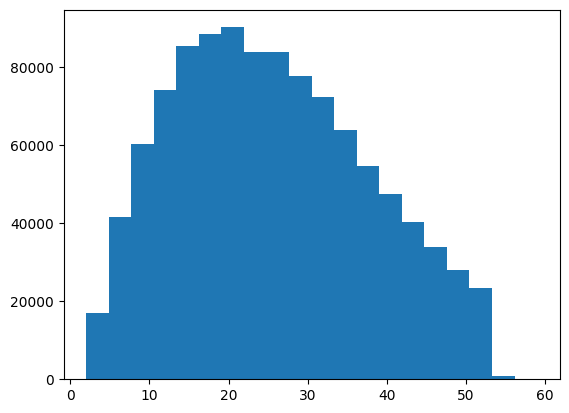

In [ ]:
plt.hist(x=a['Health Score'].values, bins=20)

In [ ]:
# a = data[['Annual Income', 'Credit Score', 'Health Score', 'Age_Income', 'Health_Income', 'Premium Amount']]
# a.dropna(inplace=True)
a = data.copy()
a = a.loc[data['Premium Amount'] < 2500, :]
a.reset_index(inplace=True, drop=True)
a

,Age,Gender,Annual Income,Education Level,Health Score,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Smoking Status,...,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House
0,39.0,0,31678.0,2,15.569731,1,12.0,694.0,2.0,1,...,False,False,False,True,True,False,False,False,False,True
1,21.0,1,141855.0,0,10.938144,0,0.0,367.0,1.0,1,...,False,False,False,True,True,False,False,True,False,False
2,21.0,1,39651.0,0,20.376094,2,8.0,598.0,4.0,1,...,False,True,False,False,True,False,False,False,False,True
3,48.0,0,127237.0,1,5.769783,1,11.0,398.0,5.0,0,...,True,False,False,False,False,True,False,False,True,False
4,21.0,1,1733.0,0,17.869551,2,10.0,685.0,8.0,0,...,False,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864332,53.0,0,6837.0,1,17.844235,1,15.0,406.0,4.0,0,...,False,True,False,False,False,False,True,False,False,True
864333,38.0,1,1607.0,1,18.552314,1,12.0,469.0,2.0,0,...,False,False,False,True,False,True,False,False,False,True
864334,34.0,1,23456.0,2,14.783439,0,12.0,548.0,9.0,0,...,False,True,False,False,True,False,False,True,False,False
864335,36.0,0,27316.0,2,13.772907,2,5.0,372.0,3.0,0,...,False,False,True,False,False,False,True,True,False,False


In [ ]:
a.corr(method='pearson')['Premium Amount'].sort_values(ascending=False)

,Premium Amount
Premium Amount,1.000000
Marital Status_Unknown,0.013821
Health Score,0.013732
Occupation_Employed,0.003733
Vehicle Age,0.000963
Property Type_House,0.000822
Location_Urban,0.000374
Insurance Duration,0.000307
Occupation_Self-Employed,0.000291
Property Type_Apartment,0.000278


1. initial EDA on Age = -0.002
2. Health Score = 0.016
3. Number of Dependants = -0.001225
4. Credit Score = -0.04
5.

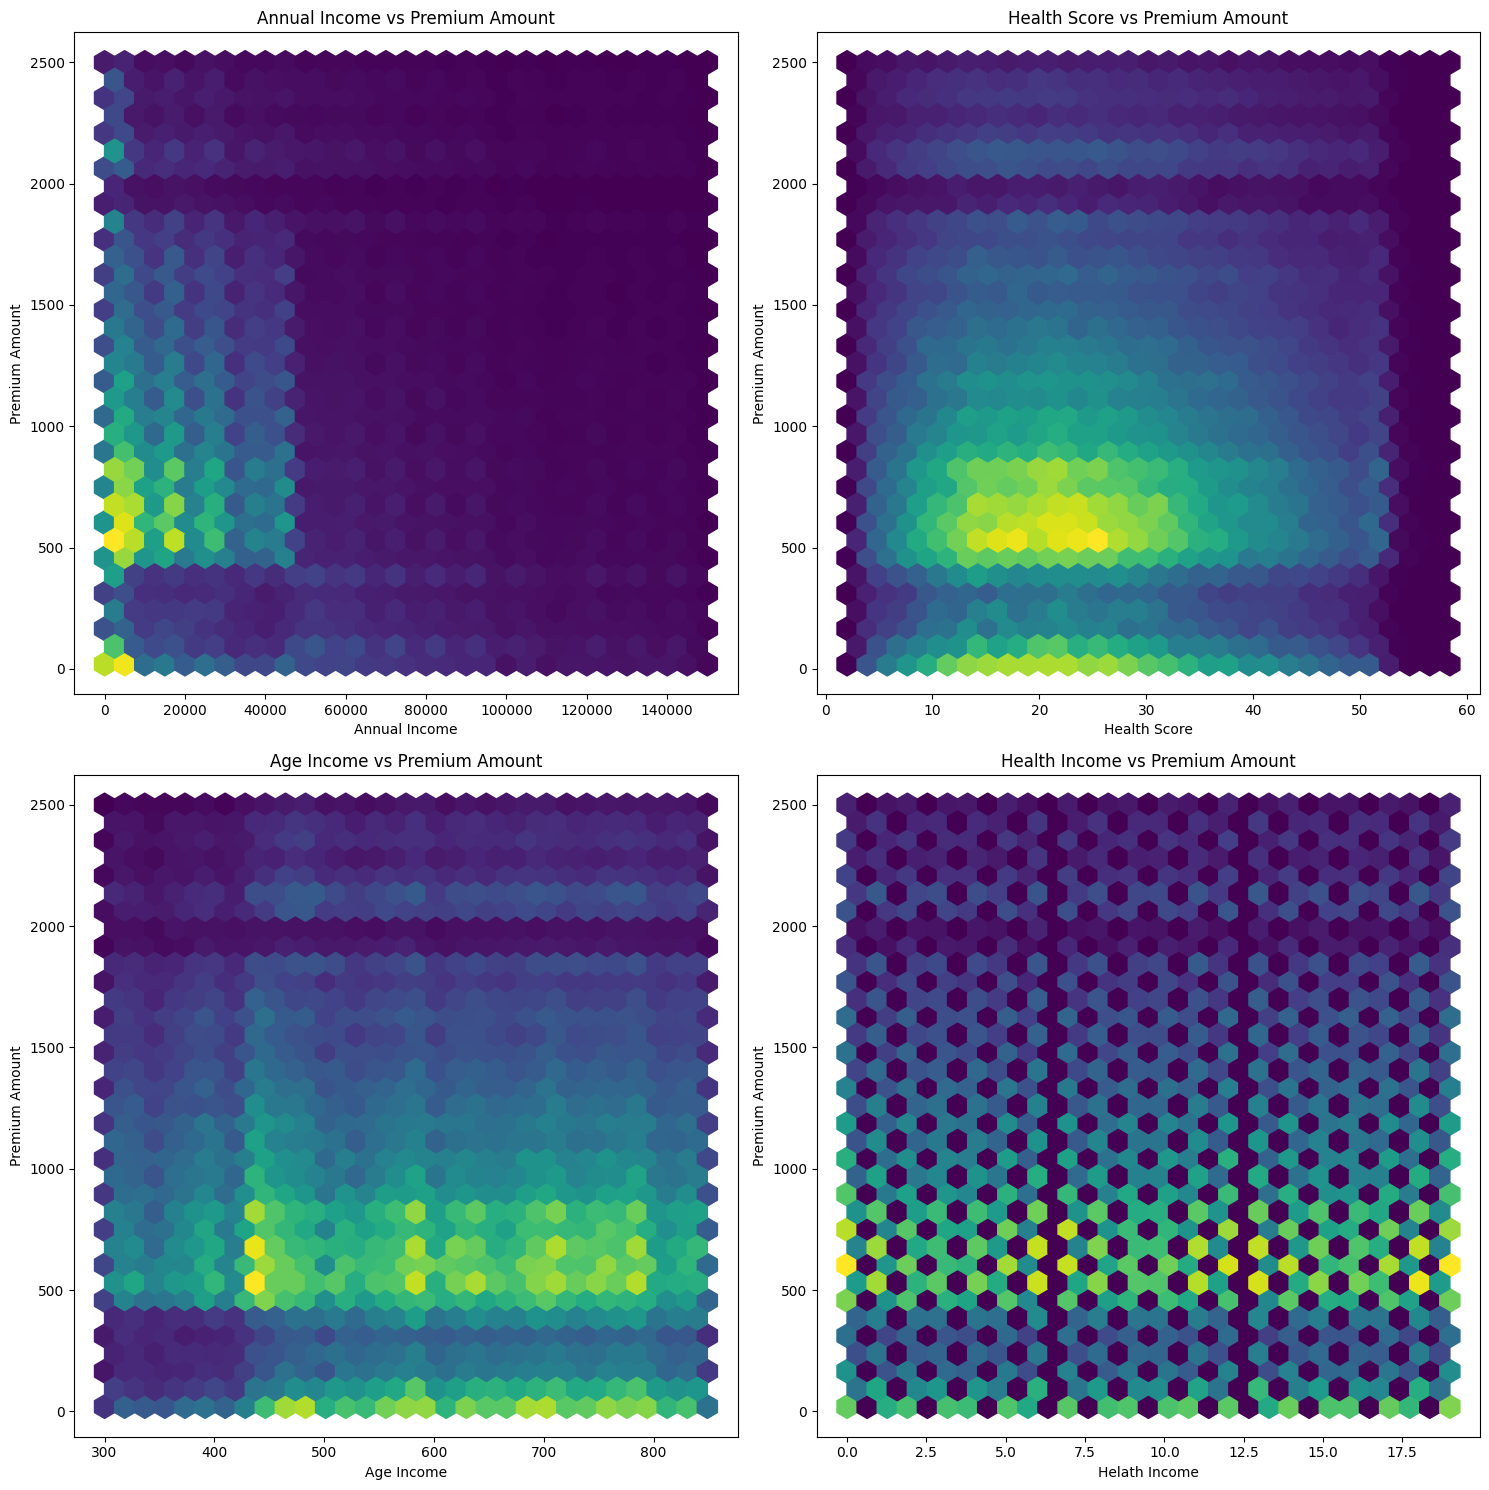

In [ ]:

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.hexbin(data=a, x='Annual Income', y='Premium Amount', gridsize=30, cmap='viridis')
plt.title('Annual Income vs Premium Amount')
plt.xlabel('Annual Income')
plt.ylabel('Premium Amount')

plt.subplot(222)
plt.hexbin(data=a, x='Health Score', y='Premium Amount', gridsize=30, cmap='viridis')
plt.title('Health Score vs Premium Amount')
plt.xlabel('Health Score')
plt.ylabel('Premium Amount')

plt.subplot(223)
plt.hexbin(data=a, x='Credit Score', y='Premium Amount', gridsize=30, cmap='viridis')
plt.title('Age Income vs Premium Amount')
plt.xlabel('Age Income')
plt.ylabel('Premium Amount')

plt.subplot(224)
plt.hexbin(data=a, x='Vehicle Age', y='Premium Amount', gridsize=30, cmap='viridis')
plt.title('Health Income vs Premium Amount')
plt.xlabel('Helath Income')
plt.ylabel('Premium Amount')

plt.tight_layout()
plt.show()
# b = data['Premium Amount'].values[:300000]

# plt.figure(figsize=(10,5))
# plt.hist(b, bins=500)
# plt.show()

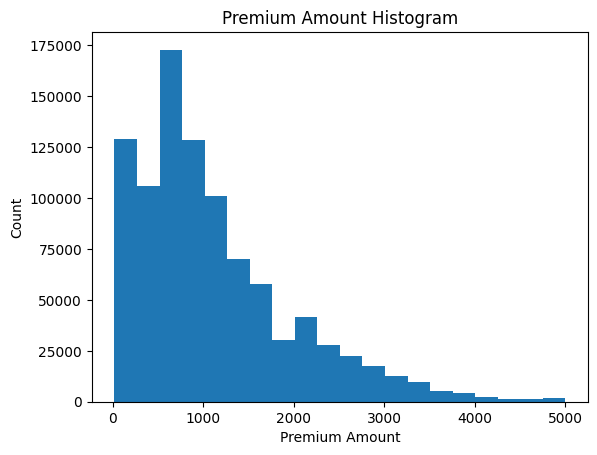

In [ ]:
plt.hist(x=data['Premium Amount'], bins=20)
plt.title('Premium Amount Histogram')
plt.xlabel('Premium Amount')
plt.ylabel('Count')
plt.show()

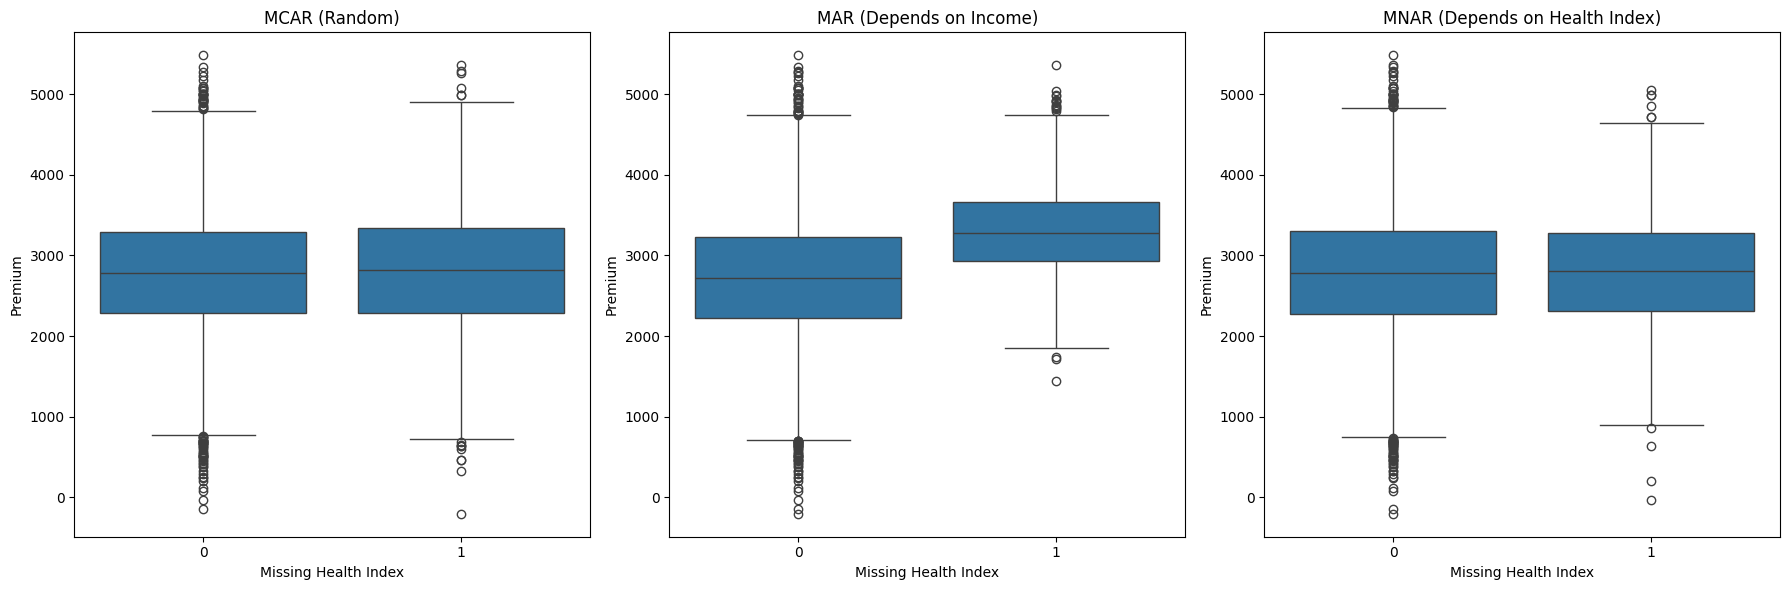

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Create synthetic dataset
n = 10000
age = np.random.randint(20, 65, size=n)
income = np.random.normal(50000, 15000, size=n)
health_index = np.random.normal(70, 10, size=n)
premium = 500 + 0.05 * income - 3 * health_index + np.random.normal(0, 50, size=n)

df = pd.DataFrame({
    "Age": age,
    "Income": income,
    "Health Index": health_index,
    "Premium": premium
})

# Simulate MCAR: completely random missing values
df_mcar = df.copy()
mask_mcar = np.random.rand(n) < 0.2
df_mcar.loc[mask_mcar, "Health Index"] = np.nan
df_mcar["missing_health_index"] = df_mcar["Health Index"].isna().astype(int)

# Simulate MAR: missingness depends on another observed variable (e.g., Income)
df_mar = df.copy()
prob_mar = 1 / (1 + np.exp(-(df_mar["Income"] - 50000)/5000))  # higher income -> more likely to be missing
mask_mar = np.random.rand(n) < prob_mar * 0.2
df_mar.loc[mask_mar, "Health Index"] = np.nan
df_mar["missing_health_index"] = df_mar["Health Index"].isna().astype(int)

# Simulate MNAR: missingness depends on Health Index itself (unobserved)
df_mnar = df.copy()
prob_mnar = 1 / (1 + np.exp(-(df_mnar["Health Index"] - 70)/5))  # lower health -> more likely to be missing
mask_mnar = np.random.rand(n) < prob_mnar * 0.2
df_mnar.loc[mask_mnar, "Health Index"] = np.nan
df_mnar["missing_health_index"] = df_mnar["Health Index"].isna().astype(int)

# Plot boxplots comparing missingness to Premium
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for ax, data, title in zip(
    axs,
    [df_mcar, df_mar, df_mnar],
    ["MCAR (Random)", "MAR (Depends on Income)", "MNAR (Depends on Health Index)"]
):
    sns.boxplot(x="missing_health_index", y="Premium", data=data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Missing Health Index")
    ax.set_ylabel("Premium")

plt.tight_layout()
plt.show()


<Axes: xlabel='missing_health_index', ylabel='Premium Amount'>

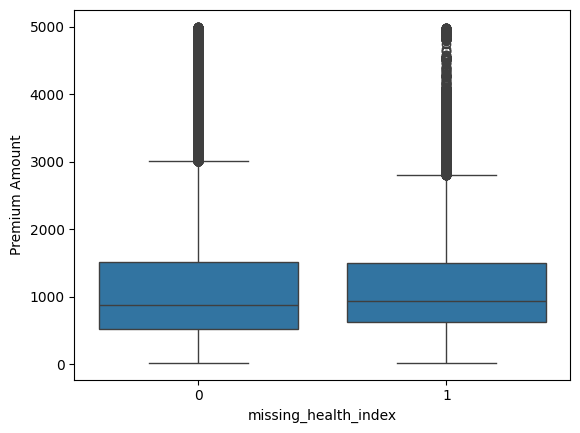

In [ ]:
data['missing_health_index'] = data['Health Score'].isna().astype(int)
sns.boxplot(x='missing_health_index', y='Premium Amount', data=data)

In [ ]:
from sklearn.model_selection import train_test_split

d.drop(columns='Credit Score', inplace=True)
features = [i for i in d.columns if (i != 'Health Score') and (i != 'Premium Amount')]
# features = ['Annual Income']
train_data = d[d['Health Score'].notna()]

train_data['Health Score'] = train_data['Health Score'].apply(np.ceil).astype(int)
train_data['Annual Income'] = train_data['Annual Income'] / 1000
train_data['Annual Income'] = train_data['Annual Income'].apply(np.ceil).astype(int)
train_data = outlier_fx(train_data, 'Health Score')
train_data = outlier_fx(train_data, 'Annual Income')

x_train_clean, x_test_clean, y_train_clean, y_test_clean = train_test_split(train_data[features], train_data['Health Score'], test_size=0.2, random_state=42)
missing_data = d[d['Health Score'].isna()]

<ipython-input-26-0d3aad8a3d7c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Health Score'] = train_data['Health Score'].apply(np.ceil).astype(int)
<ipython-input-26-0d3aad8a3d7c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Annual Income'] = train_data['Annual Income'] / 1000
<ipython-input-26-0d3aad8a3d7c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

100%|===================| 105960/106026 [11:23<00:00]       

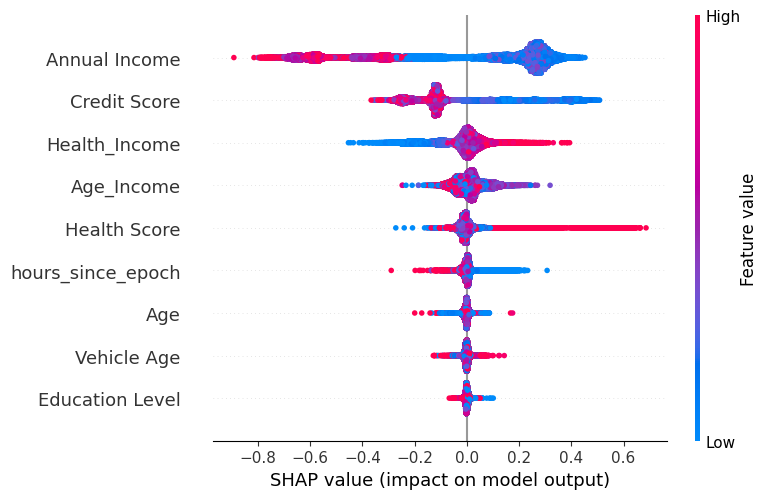

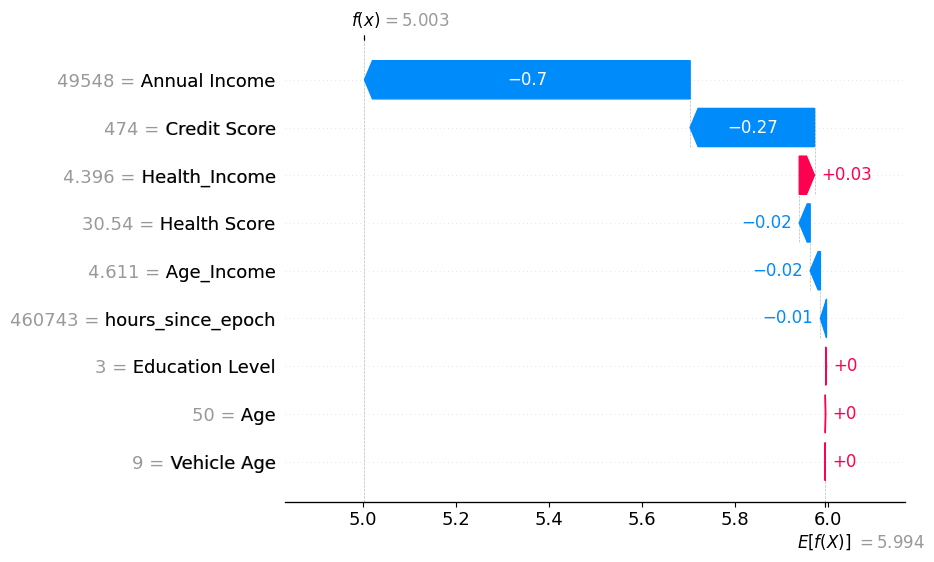

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap

X = a.select_dtypes(include=np.number).drop(columns='Premium Amount', errors='ignore')
y = np.log1p(a['Premium Amount'])  # or raw, if preferred

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)

# Global view: feature importance
shap.summary_plot(shap_values, X_val)

# Local view: a specific example
shap.plots.waterfall(shap_values[0])